In [73]:
import dwdatareader as dw
import matplotlib.pyplot as plt 
import noisereduce as nr
from IPython.display import Audio
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy.signal import butter,filtfilt
import numpy as np
import acoustics.signal as S
import pandas as pd
import re
import os
import librosa as l
import scipy
import PyOctaveBand
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import mixture
from sklearn.svm import SVC
import more_itertools as mit
import seaborn as sns
import math
import os
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from scipy.fftpack import dct
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import percentile
from model import machine
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt
from sklearn.metrics import f1_score
from mlxtend.evaluate import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
import random
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.metrics import auc,roc_curve,precision_recall_curve

In [74]:
def train_model_time_auto(train_no_cavity, val_no_cavity):
    '''
        Train Autoencoder for time domain features
        Input: 
            train dataset
            validation data set
        Output: 
            autoencoder model
    '''
    nb_epoch = 100
    batch_size = 32
    input_dim = train_no_cavity.shape[1] #num of predictor variables, 
    encoding_dim = 4
    hidden_dim = int(encoding_dim / 2)
    learning_rate = 1e-3

    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(encoding_dim, activation="relu")(decoder)
    decoder = Dense(input_dim, activation="linear")(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.summary()

    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                                save_best_only=True,
                                verbose=0)
    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    history = autoencoder.fit(train_no_cavity, train_no_cavity,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(val_no_cavity, val_no_cavity),
                        verbose=1,
                        callbacks=[cp, tb]).history
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    return autoencoder

def evaluate_model_auto(autoencoder, val_no_cavity, val_labels,test_data,test_labels, threshold,val):
    '''
        Evaluate autoencoder model results
        Input:
            autoencoder model
            validation dataset
            validation labels
            test dataset
            test labels

        Output:
        None
    '''
    valid_x_predictions = autoencoder.predict(val_no_cavity)
    mse = np.mean(np.power(val_no_cavity - valid_x_predictions, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': val_labels[val_labels==0]})
    # precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
    # plt.plot(threshold_rt, precision_rt[1:], label="Precision")
    # plt.plot(threshold_rt, recall_rt[1:], label="Recall")
    # plt.title('Precision and recall for different threshold values')
    # plt.xlabel('Threshold')
    # plt.ylabel('Precision/Recall')
    # plt.legend()
    # plt.show()
    print(test_data.shape)
    test_x_predictions = autoencoder.predict(test_data)
    mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
    error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': test_labels})
    error_df_test = error_df_test.reset_index()
    threshold_fixed = threshold#0.00008
    groups = error_df_test.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "abnormal" if name == 1 else "Normal")
    ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show();

    pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
    cM = metrics.confusion_matrix(error_df_test.True_class, pred_y)
    # plt.figure(figsize=(5, 5))
    # sns.heatmap(conf_matrix, annot=True, fmt="d");
    # plt.title("Confusion matrix")
    # plt.ylabel('True class')
    # plt.xlabel('Predicted class')
    # plt.show()

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cM.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cM.flatten()/np.sum(cM)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cM, annot=labels, fmt='', cmap='Blues',cbar=False)

    ax.set_title('Confusion Matrix for Section'+val+'\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Abnormal'])
    ax.yaxis.set_ticklabels(['Normal','Abnormal'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

    cR=metrics.classification_report(error_df_test.True_class, pred_y)
    print("ClassificationReport \n",cR)

    labels = np.arange(2)
    target_names = ['Normal','Abnormal']
    cR=metrics.classification_report(test_labels, pred_y,labels=labels,target_names=target_names,output_dict=True)
    print("Classification Report \n",cR)   

    ax=sns.heatmap(pd.DataFrame(cR).iloc[:-1, :-3].T, annot=True, cbar=False)
    ax.set_title('Classification report for Section'+val+'\n\n');
    plt.show()

    bal_accuracy= balanced_accuracy_score(error_df_test.True_class, pred_y)
    print("Balanced accuracy",bal_accuracy)
    Accuracy= accuracy_score(error_df_test.True_class, pred_y)
    print("Accuracy",Accuracy)

def split_cavity_not(x_train_new, x_val, y_train_new, y_val):
    '''
        Divide train and validation datasets into cavity and not cavity
        to train autoencoder on only not cavity dataset
        Input:
            train dataset
            validation dataset
            train labels
            validation labels
        Output:
            train no cavity dataset
            train cavity dataset
            validation no cavity dataset
            validation cavity dataset

    '''
    train_d=pd.DataFrame(x_train_new)
    train_d.reset_index(drop=True,inplace=True)

    train_l=pd.DataFrame(y_train_new)
    train_l.reset_index(drop=True,inplace=True)

    train_df=pd.concat([train_d,train_l],axis=1,ignore_index=True)
    train_df.rename(columns={train_df.columns[-1]:'label'},inplace=True)

    train_no_cavity = train_df.loc[train_df['label']==0]
    train_cavity = train_df.loc[train_df['label']==1]

    # Val data
    val_d=pd.DataFrame(x_val)
    val_d.reset_index(drop=True,inplace=True)

    val_l=pd.DataFrame(y_val)
    val_l.reset_index(drop=True,inplace=True)

    val_df=pd.concat([val_d,val_l],axis=1,ignore_index=True)
    val_df.rename(columns={val_df.columns[-1]:'label'},inplace=True)

    val_no_cavity = val_df.loc[val_df['label']==0]
    val_cavity = val_df.loc[val_df['label']==0]
    return train_no_cavity,train_cavity,val_no_cavity,val_cavity

In [75]:
def ROC_plot(model1, model2, model3,test_data, test_labels,threshold):
    '''
        Plot ROC-AUC for three model, i.e., Random, SVM and Autoencoder
        Input:
            model1, model2 and model3 : random, SVM and Autoencoder models
            test datasets
            test labels
            threshold for autoencoder
    '''
    # Autoencoder
    test_x_predictions = model1.predict(test_data)
    mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
    error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': test_labels})
    error_df_test = error_df_test.reset_index()
    threshold_fixed = threshold
    false_pos_rate1, true_pos_rate1, thresholds1 = roc_curve(error_df_test.True_class, error_df_test.Reconstruction_error)
    roc_auc1 = auc(false_pos_rate1, true_pos_rate1,)

    # Random forest
    false_pos_rate2, true_pos_rate2, thresholds2 = roc_curve(np.array(test_labels).ravel().astype(int),model2.predict_proba(test_data)[:,1])
    roc_auc2 = metrics.auc(false_pos_rate2, true_pos_rate2,)

    # Support vector machine
    false_pos_rate3, true_pos_rate3, thresholds3 = roc_curve(np.array(test_labels).ravel().astype(int),model3.predict_proba(test_data)[:,1])
    roc_auc3 = metrics.auc(false_pos_rate3, true_pos_rate3,)
    
    plt.plot(false_pos_rate1, true_pos_rate1, label='Autoencoder AUC = %0.3f'% roc_auc1)
    plt.plot(false_pos_rate2, true_pos_rate2, label='Random forest AUC = %0.3f'% roc_auc2)
    plt.plot(false_pos_rate3, true_pos_rate3, label='Support vector machine AUC = %0.3f'% roc_auc3)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

In [76]:
def train_model(train_data, train_label,model_name):
    '''
        Train random and SVM models
        Input: 
            train dataset
            Train labels
            model name random or SVM
        Output: 
            trained model 
    '''
    if model_name=='Random':
        num_trees = 1066 #1000
        max_depth = 98 #100
        model = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=5, criterion="entropy", verbose=0,class_weight='balanced')
        model.fit(train_data, train_label)
    elif model_name=='SVM':
        gamma=1
        C=10
        model=SVC(kernel='rbf',gamma=gamma, C=C,probability=True)
        model.fit(train_data, train_label)
    return model
    
def evaluation_matrix(model, train_data, train_label, test_data, test_label,val):
    '''
        Evaluate random and SVM model results
        Input:
            model: random or SVM
            train dataset
            train label
            test dataset
            test labels  
    '''
    cM=metrics.confusion_matrix(test_label, model.predict(test_data))
    print("Confusion matrix \n",cM)
    tn, fp, fn, tp = metrics.confusion_matrix(test_label, model.predict(test_data)).ravel()
    print(tn,fp,fn,tp)
    
    sensitivity=tp/(tp+fn)
    specificity=tn/(tn+fp)
    actual_balanced_accuracy= (specificity+sensitivity)/2
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cM.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cM.flatten()/np.sum(cM)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cM, annot=labels, fmt='', cmap='Blues',cbar=False)

    ax.set_title('Confusion Matrix for Section '+val+'\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Abnormal'])
    ax.yaxis.set_ticklabels(['Normal','Abnormal'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    

    bal_accuracy= balanced_accuracy_score(test_label, model.predict(test_data))
    print("Balance Accuracy",bal_accuracy)
    print("actual balanced accuracy formula=",actual_balanced_accuracy)
    Accuracy= accuracy_score(test_label, model.predict(test_data))
    print("Balance Accuracy=",Accuracy)
    print("Class wise accuracy",cM.diagonal()/cM.sum(axis=1))
    # print("Per class accuracy class 1", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=1))
    # print("Per class accuracy class 0", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=0))
    # print("average per class  accuracy", accuracy_score(test_label, model.predict(test_data),method='average'))

    cR=metrics.classification_report(test_label, model.predict(test_data))
    print("ClassificationReport \n",cR)   

    labels = np.arange(2)
    target_names = ['Normal','Abnormal']
    cR=metrics.classification_report(test_label, model.predict(test_data),labels=labels,target_names=target_names,output_dict=True)
    print("ClassificationReport \n",cR)   

    ax=sns.heatmap(pd.DataFrame(cR).iloc[:-1, :-2].T, annot=True,cbar=False)
    ax.set_title('Classification report for Section'+val+'\n\n');
    plt.show()

    # cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    # scores = cross_val_score(model,train_data, train_label, cv=cv,scoring="accuracy")
    # print('Scores',scores, np.average(scores))

    f1_weighted_1=f1_score(test_label, model.predict(test_data),average='weighted')
    print("F1 weighted",f1_weighted_1)#,f1_weighted_0)
    print("Precison weighted", precision_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))
    print("recall weighted", recall_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))

    print("Confusion matrix \n")
    ConfusionMatrixDisplay.from_predictions(test_label, model.predict(test_data))
    plt.show()
   
    # rf_disp = RocCurveDisplay.from_estimator(model, test_data, test_label)
    # plt.show()

    # fig, ax = plt.subplots(1,2,figsize=(15,6))
    # pr = skplt.metrics.plot_precision_recall(test_label, model.predict_proba(test_data),ax=ax[1])
    # roc = skplt.metrics.plot_roc(test_label, model.predict_proba(test_data),ax=ax[0])
    # plt.show()
    
def undersampling(train_data, train_label):
    '''
        Perform undersampling on training dataset using SMOTE
        Input: 
            train dataset
            train labels
        Output:
            undersampled train dataset
            undersampled train labels
    '''
    rus = RandomUnderSampler()
    undersample_data,undersample_label=rus.fit_resample(train_data, train_label)
    print("Length of train: ", len(undersample_data),"Length of label :", len(undersample_label))
    unique, counts = np.unique(undersample_label, return_counts=True)
    d3=dict(zip(unique, counts))
    print(f"Numbers of class instances (Undersampling): {d3}")
    return undersample_data, undersample_label

def normalize_data(data):
    '''
        Normalize datasets that means values lies between 0-1. 
        Input: 
            dataset
        Output:
            normalized dataset 
    '''
    norm_time=MinMaxScaler()
    norm_time.fit(data.iloc[:,:-1])
    norm_data=norm_time.transform(data.iloc[:,:-1])
    norm_data=pd.concat([pd.DataFrame(norm_data),data.iloc[:,-1:]],axis=1)

    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])
    
    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")
    return norm_data
    
def split_data(data,label):
    '''
        split data into train and testing
        Input: 
            data
            labels
        Output:
            train dataset
            test dataset
            train labels
            test labels
            train split indices
            test split indices
    '''
    indices = np.arange(len(data))
    x_train, x_test, y_train, y_test,indices_train,indices_test= train_test_split(data, label, indices, test_size=0.2,random_state=20,shuffle=True)
    return x_train, x_test, y_train, y_test,indices_train,indices_test

# Experiment 1: Time domain features 

1. model1: Random forest
2. model2: Support vector machine 
3. model3: Autoencoder

################################### SECTION II ######################################################################
Numbers of class instances (Raw): {0: 3243, 1: 52351}
Numbers of class instances (Raw): {0: 3243, 1: 52351}
Length of train:  44475 Length of test : 11119
Numbers of class instances (Train): {0: 2595, 1: 41880}
Numbers of class instances (Test): {0: 648, 1: 10471}
Length of train:  5190 Length of label : 5190
Numbers of class instances (Undersampling): {0: 2595, 1: 2595}
---------------Train Random forest----------------
Confusion matrix 
 [[ 469  179]
 [3381 7090]]
469 179 3381 7090


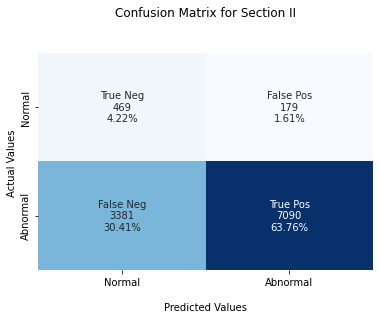

Balance Accuracy 0.7004368178543678
actual balanced accuracy formula= 0.7004368178543678
Balance Accuracy= 0.6798273226009534
Class wise accuracy [0.72376543 0.6771082 ]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.12      0.72      0.21       648
           1       0.98      0.68      0.80     10471

    accuracy                           0.68     11119
   macro avg       0.55      0.70      0.50     11119
weighted avg       0.93      0.68      0.76     11119

ClassificationReport 
 {'Normal': {'precision': 0.12181818181818181, 'recall': 0.7237654320987654, 'f1-score': 0.2085371276122721, 'support': 648}, 'Abnormal': {'precision': 0.9753748796258083, 'recall': 0.6771082036099704, 'f1-score': 0.7993235625704623, 'support': 10471}, 'accuracy': 0.6798273226009534, 'macro avg': {'precision': 0.548596530721995, 'recall': 0.7004368178543678, 'f1-score': 0.5039303450913672, 'support': 11119}, 'weighted avg': {'precision': 0.92563077132655

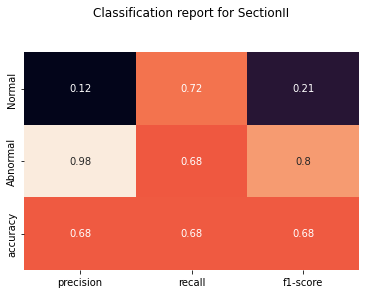

F1 weighted 0.7648933431394968
Precison weighted 0.9256307713265598
recall weighted 0.6798273226009534
Confusion matrix 



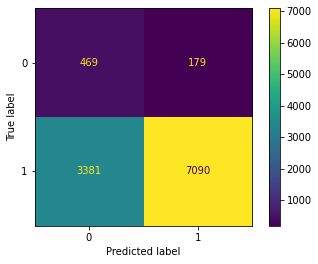

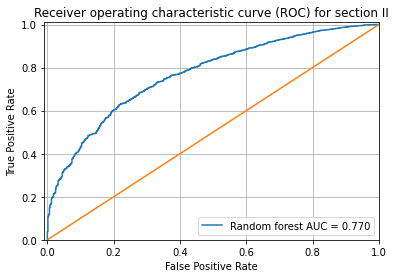

-------------------Train SVM----------------------
Confusion matrix 
 [[ 503  145]
 [5462 5009]]
503 145 5462 5009


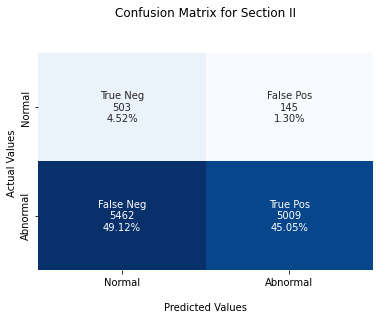

Balance Accuracy 0.6273016980466921
actual balanced accuracy formula= 0.6273016980466921
Balance Accuracy= 0.4957280330965015
Class wise accuracy [0.77623457 0.47836883]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.08      0.78      0.15       648
           1       0.97      0.48      0.64     10471

    accuracy                           0.50     11119
   macro avg       0.53      0.63      0.40     11119
weighted avg       0.92      0.50      0.61     11119

ClassificationReport 
 {'Normal': {'precision': 0.084325230511316, 'recall': 0.7762345679012346, 'f1-score': 0.15212460305458944, 'support': 648}, 'Abnormal': {'precision': 0.9718665114474195, 'recall': 0.47836882819214976, 'f1-score': 0.641152, 'support': 10471}, 'accuracy': 0.4957280330965015, 'macro avg': {'precision': 0.5280958709793677, 'recall': 0.6273016980466921, 'f1-score': 0.39663830152729473, 'support': 11119}, 'weighted avg': {'precision': 0.9201418284681413, 'rec

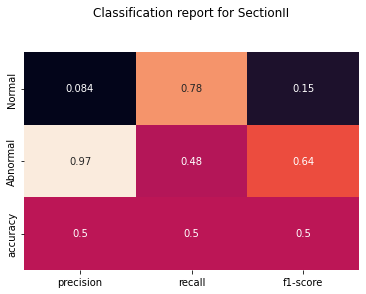

F1 weighted 0.6126521570986038
Precison weighted 0.9201418284681413
recall weighted 0.4957280330965015
Confusion matrix 



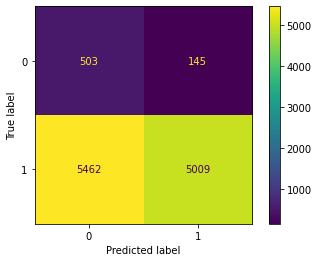

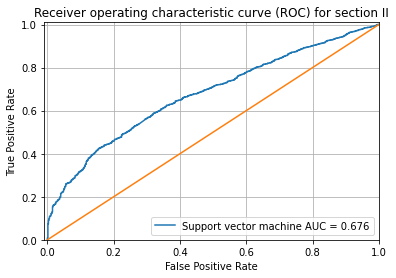

--------------------Train Autoencoder---------------
(2066, 8) (529, 8)
Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_542 (Dense)           (None, 4)                 32        
                                                                 
 dense_543 (Dense)           (None, 2)                 10        
                                                                 
 dense_544 (Dense)           (None, 2)                 6         
                                                                 
 dense_545 (Dense)           (None, 4)                 12        
                                                                 
 dense_546 (Dense)           (None, 7)                 35        
                                                    

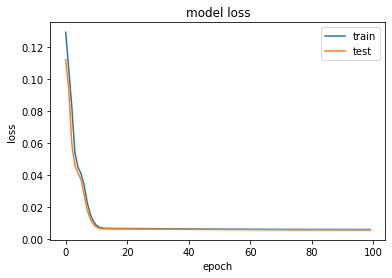

(11119, 7)


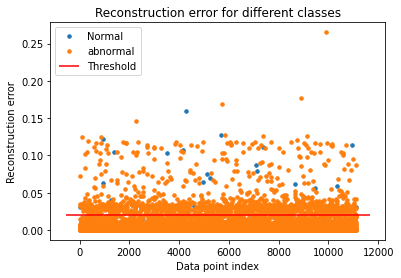

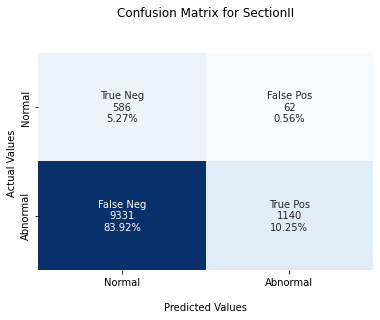

ClassificationReport 
               precision    recall  f1-score   support

           0       0.06      0.90      0.11       648
           1       0.95      0.11      0.20     10471

    accuracy                           0.16     11119
   macro avg       0.50      0.51      0.15     11119
weighted avg       0.90      0.16      0.19     11119

Classification Report 
 {'Normal': {'precision': 0.05909045074115156, 'recall': 0.904320987654321, 'f1-score': 0.11093232371036442, 'support': 648}, 'Abnormal': {'precision': 0.9484193011647255, 'recall': 0.10887212300639862, 'f1-score': 0.1953225391930095, 'support': 10471}, 'accuracy': 0.15522978685133554, 'macro avg': {'precision': 0.5037548759529386, 'recall': 0.5065965553303599, 'f1-score': 0.15312743145168695, 'support': 11119}, 'weighted avg': {'precision': 0.8965904410986695, 'recall': 0.15522978685133554, 'f1-score': 0.19040439370935502, 'support': 11119}}


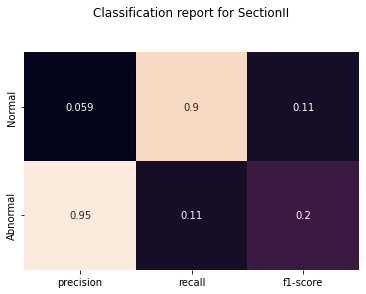

Balanced accuracy 0.5065965553303599
Accuracy 0.15522978685133554


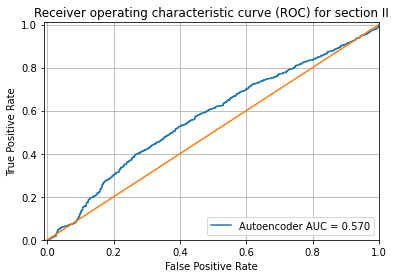

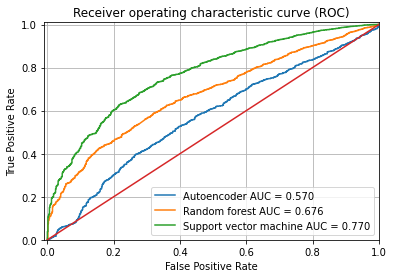

################################### SECTION III ######################################################################
Numbers of class instances (Raw): {0: 15624, 1: 4165}
Numbers of class instances (Raw): {0: 15624, 1: 4165}
Length of train:  15831 Length of test : 3958
Numbers of class instances (Train): {0: 12440, 1: 3391}
Numbers of class instances (Test): {0: 3184, 1: 774}
Length of train:  6782 Length of label : 6782
Numbers of class instances (Undersampling): {0: 3391, 1: 3391}
---------------Train Random forest----------------
Confusion matrix 
 [[2568  616]
 [ 160  614]]
2568 616 160 614


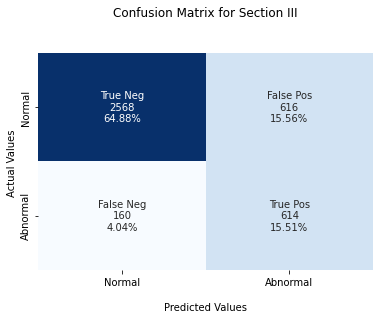

Balance Accuracy 0.7999071585316765
actual balanced accuracy formula= 0.7999071585316765
Balance Accuracy= 0.8039413845376453
Class wise accuracy [0.80653266 0.79328165]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      3184
           1       0.50      0.79      0.61       774

    accuracy                           0.80      3958
   macro avg       0.72      0.80      0.74      3958
weighted avg       0.85      0.80      0.82      3958

ClassificationReport 
 {'Normal': {'precision': 0.9413489736070382, 'recall': 0.8065326633165829, 'f1-score': 0.8687415426251692, 'support': 3184}, 'Abnormal': {'precision': 0.4991869918699187, 'recall': 0.7932816537467701, 'f1-score': 0.6127744510978044, 'support': 774}, 'accuracy': 0.8039413845376453, 'macro avg': {'precision': 0.7202679827384785, 'recall': 0.7999071585316765, 'f1-score': 0.7407579968614868, 'support': 3958}, 'weighted avg': {'precision': 0.8548827346316642

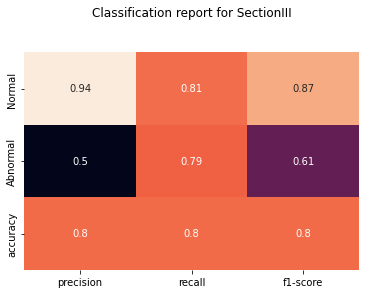

F1 weighted 0.8186863306892974
Precison weighted 0.8548827346316642
recall weighted 0.8039413845376453
Confusion matrix 



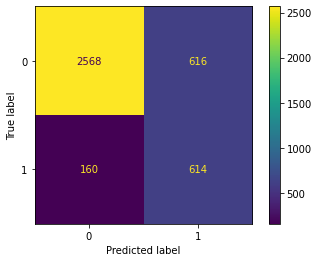

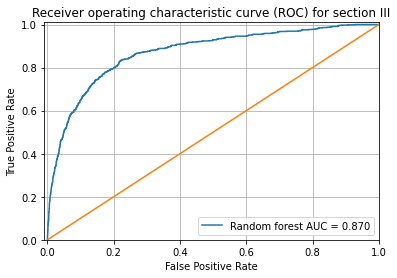

-------------------Train SVM----------------------
Confusion matrix 
 [[2349  835]
 [ 253  521]]
2349 835 253 521


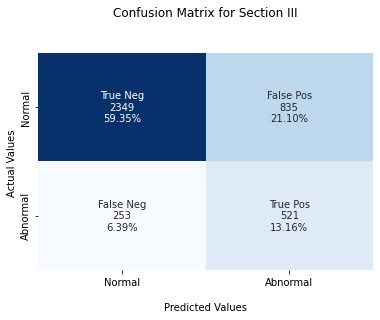

Balance Accuracy 0.7054389356342436
actual balanced accuracy formula= 0.7054389356342436
Balance Accuracy= 0.7251136937847398
Class wise accuracy [0.73775126 0.67312661]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      3184
           1       0.38      0.67      0.49       774

    accuracy                           0.73      3958
   macro avg       0.64      0.71      0.65      3958
weighted avg       0.80      0.73      0.75      3958

ClassificationReport 
 {'Normal': {'precision': 0.9027671022290545, 'recall': 0.737751256281407, 'f1-score': 0.8119599032146562, 'support': 3184}, 'Abnormal': {'precision': 0.38421828908554573, 'recall': 0.6731266149870802, 'f1-score': 0.4892018779342722, 'support': 774}, 'accuracy': 0.7251136937847398, 'macro avg': {'precision': 0.6434926956573002, 'recall': 0.7054389356342436, 'f1-score': 0.6505808905744642, 'support': 3958}, 'weighted avg': {'precision': 0.8013631655506626

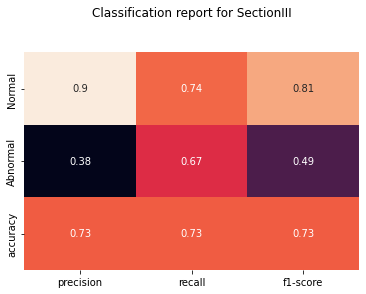

F1 weighted 0.7488435031219283
Precison weighted 0.8013631655506626
recall weighted 0.7251136937847398
Confusion matrix 



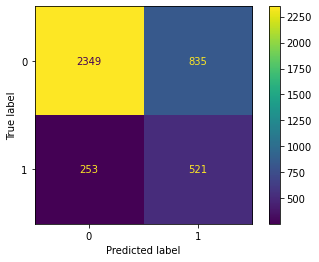

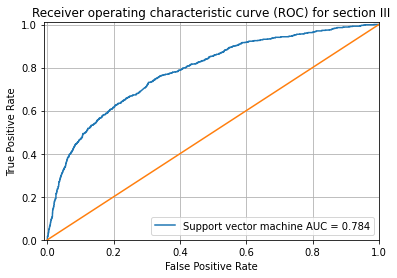

--------------------Train Autoencoder---------------
(9901, 8) (2539, 8)
Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_547 (Dense)           (None, 4)                 32        
                                                                 
 dense_548 (Dense)           (None, 2)                 10        
                                                                 
 dense_549 (Dense)           (None, 2)                 6         
                                                                 
 dense_550 (Dense)           (None, 4)                 12        
                                                                 
 dense_551 (Dense)           (None, 7)                 35        
                                                   

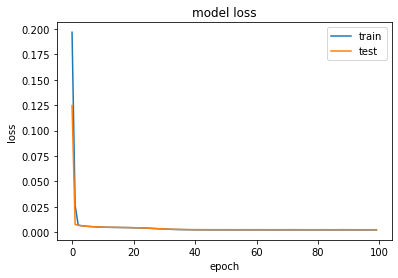

(3958, 7)


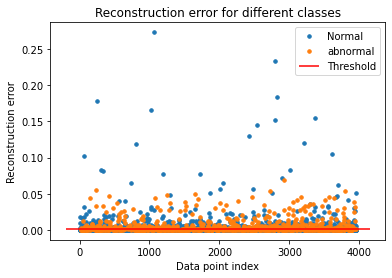

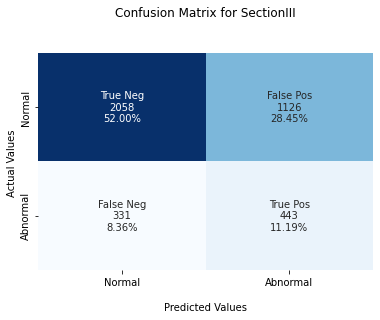

ClassificationReport 
               precision    recall  f1-score   support

           0       0.86      0.65      0.74      3184
           1       0.28      0.57      0.38       774

    accuracy                           0.63      3958
   macro avg       0.57      0.61      0.56      3958
weighted avg       0.75      0.63      0.67      3958

Classification Report 
 {'Normal': {'precision': 0.8614483047300125, 'recall': 0.6463567839195979, 'f1-score': 0.738560918715234, 'support': 3184}, 'Abnormal': {'precision': 0.28234544295729763, 'recall': 0.5723514211886305, 'f1-score': 0.3781476739223218, 'support': 774}, 'accuracy': 0.6318847902981304, 'macro avg': {'precision': 0.5718968738436551, 'recall': 0.6093541025541143, 'f1-score': 0.5583542963187779, 'support': 3958}, 'weighted avg': {'precision': 0.7482028234232715, 'recall': 0.6318847902981304, 'f1-score': 0.6680809158173779, 'support': 3958}}


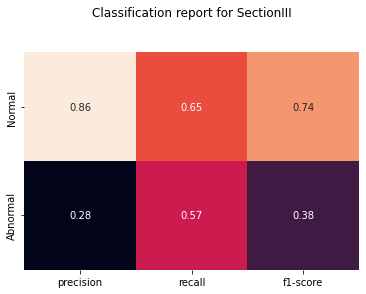

Balanced accuracy 0.6093541025541143
Accuracy 0.6318847902981304


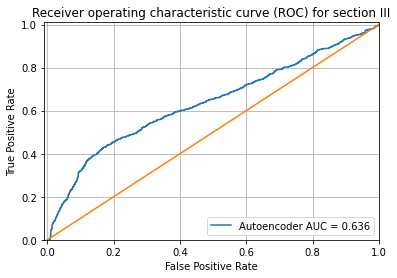

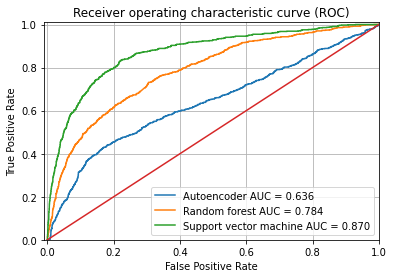

################################### SECTION IV ######################################################################
Numbers of class instances (Raw): {0: 45170, 1: 10732}
Numbers of class instances (Raw): {0: 45170, 1: 10732}
Length of train:  44721 Length of test : 11181
Numbers of class instances (Train): {0: 36164, 1: 8557}
Numbers of class instances (Test): {0: 9006, 1: 2175}
Length of train:  17114 Length of label : 17114
Numbers of class instances (Undersampling): {0: 8557, 1: 8557}
---------------Train Random forest----------------
Confusion matrix 
 [[7132 1874]
 [ 504 1671]]
7132 1874 504 1671


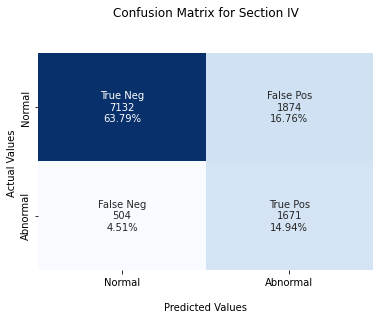

Balance Accuracy 0.7800961810900013
actual balanced accuracy formula= 0.7800961810900013
Balance Accuracy= 0.7873177712190322
Class wise accuracy [0.7919165  0.76827586]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.93      0.79      0.86      9006
           1       0.47      0.77      0.58      2175

    accuracy                           0.79     11181
   macro avg       0.70      0.78      0.72     11181
weighted avg       0.84      0.79      0.80     11181

ClassificationReport 
 {'Normal': {'precision': 0.9339968569931901, 'recall': 0.7919165001110371, 'f1-score': 0.8571085206105035, 'support': 9006}, 'Abnormal': {'precision': 0.47136812411847673, 'recall': 0.7682758620689655, 'f1-score': 0.5842657342657342, 'support': 2175}, 'accuracy': 0.7873177712190322, 'macro avg': {'precision': 0.7026824905558334, 'recall': 0.7800961810900013, 'f1-score': 0.7206871274381188, 'support': 11181}, 'weighted avg': {'precision': 0.8440033417438

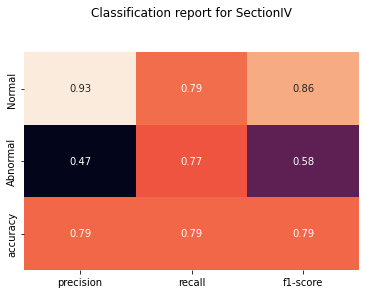

F1 weighted 0.8040333877690874
Precison weighted 0.844003341743883
recall weighted 0.7873177712190322
Confusion matrix 



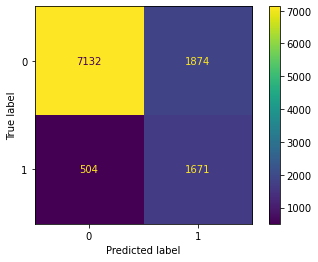

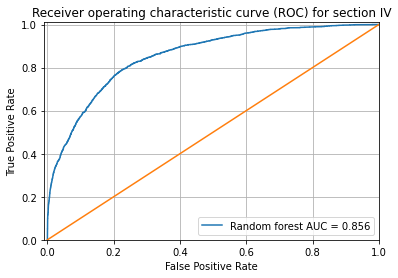

-------------------Train SVM----------------------
Confusion matrix 
 [[6826 2180]
 [ 641 1534]]
6826 2180 641 1534


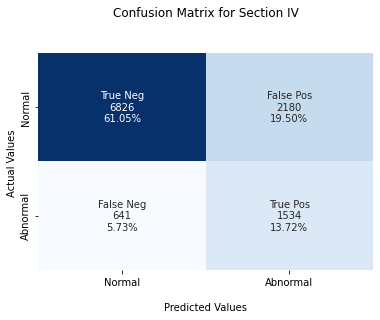

Balance Accuracy 0.7316132539992495
actual balanced accuracy formula= 0.7316132539992495
Balance Accuracy= 0.7476969859583221
Class wise accuracy [0.75793915 0.70528736]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.91      0.76      0.83      9006
           1       0.41      0.71      0.52      2175

    accuracy                           0.75     11181
   macro avg       0.66      0.73      0.67     11181
weighted avg       0.82      0.75      0.77     11181

ClassificationReport 
 {'Normal': {'precision': 0.9141556180527655, 'recall': 0.75793915167666, 'f1-score': 0.828750075881746, 'support': 9006}, 'Abnormal': {'precision': 0.4130317716747442, 'recall': 0.705287356321839, 'f1-score': 0.5209713024282561, 'support': 2175}, 'accuracy': 0.7476969859583221, 'macro avg': {'precision': 0.6635936948637549, 'recall': 0.7316132539992495, 'f1-score': 0.6748606891550011, 'support': 11181}, 'weighted avg': {'precision': 0.8166737858488305, 

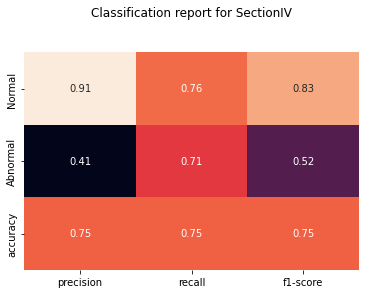

F1 weighted 0.7688789702327575
Precison weighted 0.8166737858488305
recall weighted 0.7476969859583221
Confusion matrix 



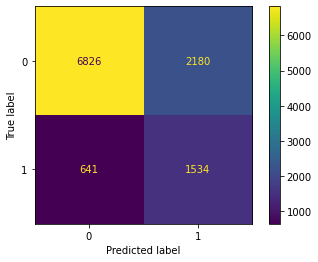

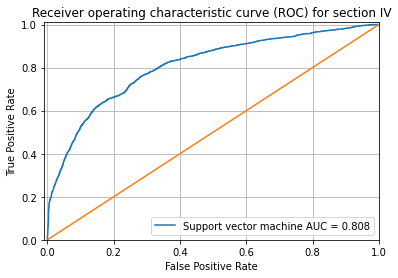

--------------------Train Autoencoder---------------
(28946, 8) (7218, 8)
Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_552 (Dense)           (None, 4)                 32        
                                                                 
 dense_553 (Dense)           (None, 2)                 10        
                                                                 
 dense_554 (Dense)           (None, 2)                 6         
                                                                 
 dense_555 (Dense)           (None, 4)                 12        
                                                                 
 dense_556 (Dense)           (None, 7)                 35        
                                                  

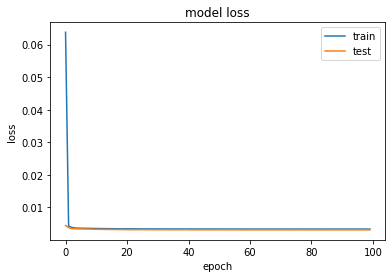

(11181, 7)


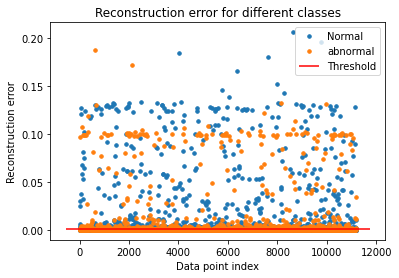

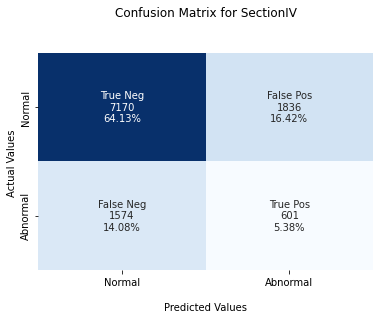

ClassificationReport 
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      9006
           1       0.25      0.28      0.26      2175

    accuracy                           0.70     11181
   macro avg       0.53      0.54      0.53     11181
weighted avg       0.71      0.70      0.70     11181

Classification Report 
 {'Normal': {'precision': 0.8199908508691675, 'recall': 0.7961359093937375, 'f1-score': 0.8078873239436619, 'support': 9006}, 'Abnormal': {'precision': 0.2466146901928601, 'recall': 0.27632183908045976, 'f1-score': 0.26062445793581956, 'support': 2175}, 'accuracy': 0.6950183346748949, 'macro avg': {'precision': 0.5333027705310138, 'recall': 0.5362288742370986, 'f1-score': 0.5342558909397408, 'support': 11181}, 'weighted avg': {'precision': 0.7084540339949192, 'recall': 0.6950183346748949, 'f1-score': 0.7014302330245082, 'support': 11181}}


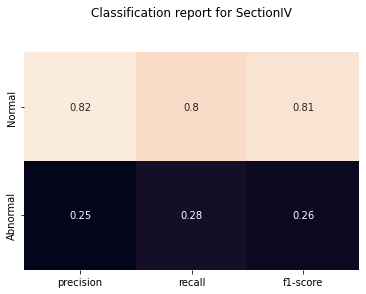

Balanced accuracy 0.5362288742370986
Accuracy 0.6950183346748949


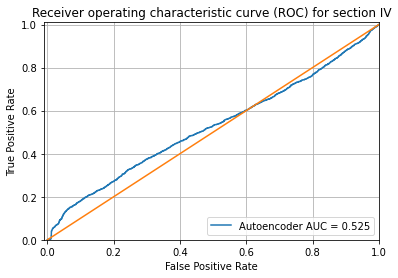

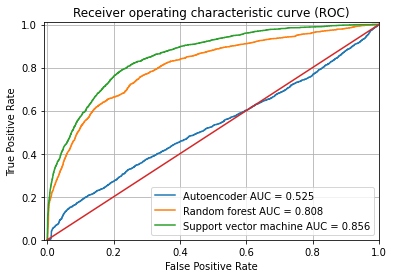

In [77]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
section=['II','III','IV']
for i,val in enumerate(section):
    print("################################### SECTION "+val+" ######################################################################")    
    df1=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/'+val+'.csv',names=time_col_list)
    df2=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/'+val+'.csv',names=time_col_list)
    df3=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/'+val+'.csv',names=time_col_list)

    new_df1=df1[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]
    new_df2=df2[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]
    new_df3=df3[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

    combined_df_time_II=pd.concat([new_df1,new_df2,new_df3],names=['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label'],ignore_index=True)
    combined_df_time_II.head()

    new_df=combined_df_time_II[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

    ## Normalize data
    norm_data= normalize_data(new_df)

    ## Separate data and label
    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])

    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")

    # partition data
    x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

    print("Length of train: ", len(x_train),"Length of test :", len(x_test))

    unique, counts = np.unique(y_train, return_counts=True)
    d1=dict(zip(unique, counts))
    print(f"Numbers of class instances (Train): {d1}")

    unique, counts = np.unique(y_test, return_counts=True)
    d2=dict(zip(unique, counts))
    print(f"Numbers of class instances (Test): {d2}")

    undersample_data, undersample_label=undersampling(x_train,y_train)

    print("---------------Train Random forest----------------")
    model1=train_model(undersample_data, undersample_label,'Random')
    evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test,val)
    # Random forest
    false_pos_rate2, true_pos_rate2, thresholds2 = roc_curve(np.array(y_test).ravel().astype(int),model1.predict_proba(x_test)[:,1])
    roc_auc2 = metrics.auc(false_pos_rate2, true_pos_rate2,)
    
    plt.plot(false_pos_rate2, true_pos_rate2, label='Random forest AUC = %0.3f'% roc_auc2)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

    print("-------------------Train SVM----------------------")
    model2=train_model(undersample_data, undersample_label,'SVM')
    evaluation_matrix(model2,undersample_data, undersample_label,x_test,y_test,val)
    false_pos_rate3, true_pos_rate3, thresholds3 = roc_curve(np.array(y_test).ravel().astype(int),model2.predict_proba(x_test)[:,1])
    roc_auc3 = metrics.auc(false_pos_rate3, true_pos_rate3,)    
    plt.plot(false_pos_rate3, true_pos_rate3, label='Support vector machine AUC = %0.3f'% roc_auc3)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()


    print("--------------------Train Autoencoder---------------")
    x_train_new, x_val, y_train_new, y_val,indices_train,indices_test=split_data(x_train,y_train)
    train_no_cavity,train_cavity,val_no_cavity,val_cavity=split_cavity_not(x_train_new, x_val, y_train_new, y_val)
    print(train_no_cavity.shape,val_no_cavity.shape)
    model3=train_model_time_auto(train_no_cavity.iloc[:,:-1], val_no_cavity.iloc[:,:-1])
    threshold=[0.02,0.001,0.001]
    evaluate_model_auto(model3, val_no_cavity.iloc[:,:-1], np.array(val_no_cavity.iloc[:,-1:]).ravel().astype(int),x_test,y_test,threshold[i],val)

    test_x_predictions = model3.predict(x_test)
    mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1)
    error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': y_test})
    error_df_test = error_df_test.reset_index()
    threshold_fixed = threshold[i]
    false_pos_rate1, true_pos_rate1, thresholds1 = roc_curve(error_df_test.True_class, error_df_test.Reconstruction_error)
    roc_auc1 = auc(false_pos_rate1, true_pos_rate1,)
    plt.plot(false_pos_rate1, true_pos_rate1, label='Autoencoder AUC = %0.3f'% roc_auc1)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

    # Plot ROC curve for three
    ROC_plot(model3,model2,model1,x_test,y_test,threshold[i])

# Experiment 2: Time-Frequency domain feature (MFCC)

1. model1: Random forest
2. model2: Support vector machine
3. modle4: Autoencoder

In [78]:
def train_model_mfcc_auto(train_no_cavity, val_no_cavity):
    nb_epoch = 100
    batch_size = 32
    input_dim = train_no_cavity.shape[1] #num of predictor variables, 
    encoding_dim = 64
    # hidden_dim = int(encoding_dim / 2)
    learning_rate = 1e-3

    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(32, activation="relu")(encoder)
    encoder = Dense(16, activation="relu")(encoder)
    encoder = Dense(8, activation="relu")(encoder)
    encoder = Dense(4, activation="relu")(encoder)
    
    decoder = Dense(4, activation="relu")(encoder)
    decoder = Dense(8, activation="relu")(decoder)
    decoder = Dense(16, activation="relu")(decoder)
    decoder = Dense(32, activation="relu")(decoder)
    decoder = Dense(encoding_dim, activation="relu")(decoder)
    decoder = Dense(input_dim, activation="linear")(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    # autoencoder.summary()

    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                                save_best_only=True,
                                verbose=0)
    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    history = autoencoder.fit(train_no_cavity, train_no_cavity,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(val_no_cavity, val_no_cavity),
                        verbose=1,
                        callbacks=[cp, tb]).history
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    return autoencoder

################################### SECTION II ######################################################################
(17328, 121) (18772, 121) (19494, 121)
(55594, 121)
Numbers of class instances (Raw): {0: 3243, 1: 52351}
Numbers of class instances (Raw): {0: 3243, 1: 52351}
Length of train:  44475 Length of test : 11119
Numbers of class instances (Train): {0: 2595, 1: 41880}
Numbers of class instances (Test): {0: 648, 1: 10471}
Length of train:  5190 Length of label : 5190
Numbers of class instances (Undersampling): {0: 2595, 1: 2595}
---------------Train Random forest----------------
Confusion matrix 
 [[ 478  170]
 [3121 7350]]
478 170 3121 7350


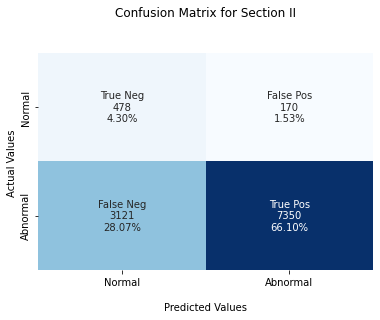

Balance Accuracy 0.7197965043960333
actual balanced accuracy formula= 0.7197965043960333
Balance Accuracy= 0.7040201456965555
Class wise accuracy [0.73765432 0.70193869]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.13      0.74      0.23       648
           1       0.98      0.70      0.82     10471

    accuracy                           0.70     11119
   macro avg       0.56      0.72      0.52     11119
weighted avg       0.93      0.70      0.78     11119

ClassificationReport 
 {'Normal': {'precision': 0.13281467074187275, 'recall': 0.7376543209876543, 'f1-score': 0.2251000706380975, 'support': 648}, 'Abnormal': {'precision': 0.9773936170212766, 'recall': 0.7019386878044122, 'f1-score': 0.817075204268801, 'support': 10471}, 'accuracy': 0.7040201456965555, 'macro avg': {'precision': 0.5551041438815747, 'recall': 0.7197965043960333, 'f1-score': 0.5210876374534492, 'support': 11119}, 'weighted avg': {'precision': 0.92817271971135

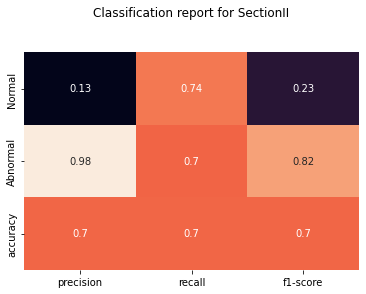

F1 weighted 0.7825757091170161
Precison weighted 0.9281727197113517
recall weighted 0.7040201456965555
Confusion matrix 



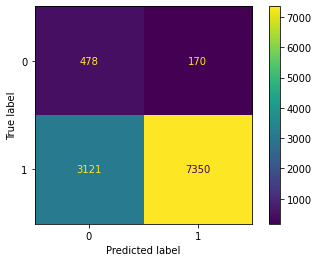

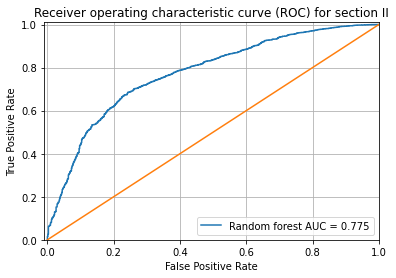

-------------------Train SVM----------------------
Confusion matrix 
 [[ 459  189]
 [2826 7645]]
459 189 2826 7645


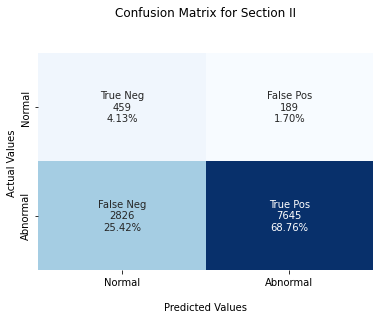

Balance Accuracy 0.7192225352561041
actual balanced accuracy formula= 0.7192225352561041
Balance Accuracy= 0.7288425218095153
Class wise accuracy [0.70833333 0.73011174]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.14      0.71      0.23       648
           1       0.98      0.73      0.84     10471

    accuracy                           0.73     11119
   macro avg       0.56      0.72      0.53     11119
weighted avg       0.93      0.73      0.80     11119

ClassificationReport 
 {'Normal': {'precision': 0.13972602739726028, 'recall': 0.7083333333333334, 'f1-score': 0.23340961098398172, 'support': 648}, 'Abnormal': {'precision': 0.9758743936686239, 'recall': 0.730111737178875, 'f1-score': 0.8352909041245562, 'support': 10471}, 'accuracy': 0.7288425218095153, 'macro avg': {'precision': 0.5578002105329422, 'recall': 0.7192225352561041, 'f1-score': 0.5343502575542689, 'support': 11119}, 'weighted avg': {'precision': 0.9271448189457

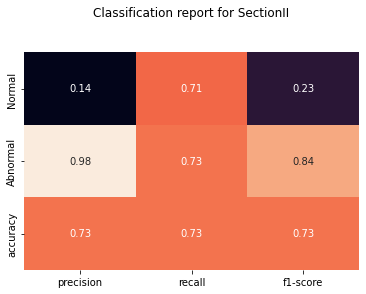

F1 weighted 0.8002140916454581
Precison weighted 0.9271448189457312
recall weighted 0.7288425218095153
Confusion matrix 



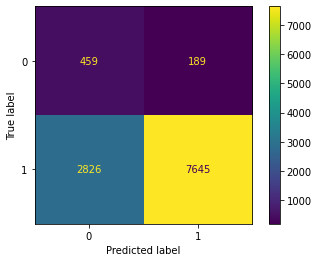

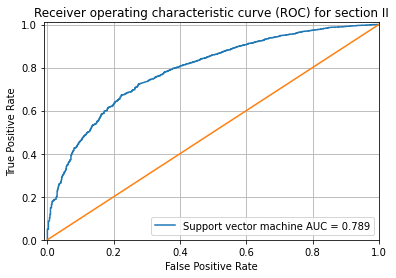

--------------------Train Autoencoder---------------
(2066, 121) (529, 121)
Epoch 1/100
65/65 [==============================] - 3s 22ms/step - loss: 0.1303 - accuracy: 0.0411 - val_loss: 0.0180 - val_accuracy: 0.0397
Epoch 2/100
65/65 [==============================] - 1s 10ms/step - loss: 0.0160 - accuracy: 0.1317 - val_loss: 0.0146 - val_accuracy: 0.1267
Epoch 3/100
65/65 [==============================] - 1s 10ms/step - loss: 0.0145 - accuracy: 0.1554 - val_loss: 0.0137 - val_accuracy: 0.1267
Epoch 4/100
65/65 [==============================] - 1s 9ms/step - loss: 0.0140 - accuracy: 0.1433 - val_loss: 0.0136 - val_accuracy: 0.1267
Epoch 5/100
65/65 [==============================] - 1s 9ms/step - loss: 0.0138 - accuracy: 0.1496 - val_loss: 0.0132 - val_accuracy: 0.1267
Epoch 6/100
65/65 [==============================] - 1s 9ms/step - loss: 0.0133 - accuracy: 0.1554 - val_loss: 0.0126 - val_accuracy: 0.1267
Epoch 7/100
65/65 [==============================] - 1s 9ms/step - loss: 0.

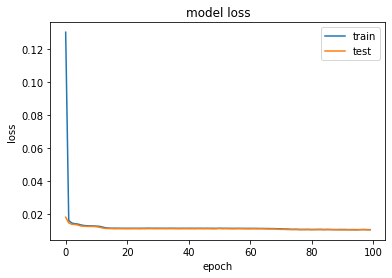

(11119, 120)


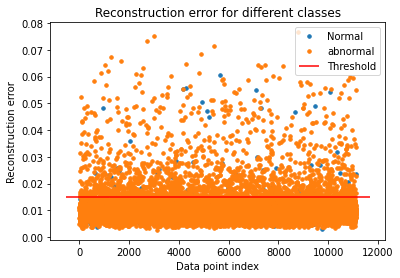

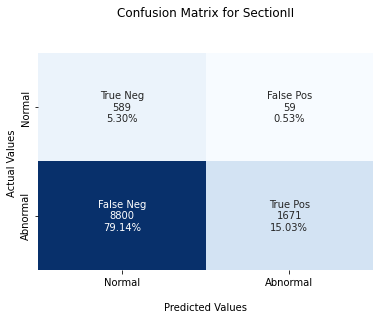

ClassificationReport 
               precision    recall  f1-score   support

           0       0.06      0.91      0.12       648
           1       0.97      0.16      0.27     10471

    accuracy                           0.20     11119
   macro avg       0.51      0.53      0.20     11119
weighted avg       0.91      0.20      0.26     11119

Classification Report 
 {'Normal': {'precision': 0.0627329854084567, 'recall': 0.9089506172839507, 'f1-score': 0.11736574673707284, 'support': 648}, 'Abnormal': {'precision': 0.9658959537572255, 'recall': 0.15958361188043166, 'f1-score': 0.27391197442832554, 'support': 10471}, 'accuracy': 0.20325568846119255, 'macro avg': {'precision': 0.5143144695828411, 'recall': 0.5342671145821911, 'f1-score': 0.1956388605826992, 'support': 11119}, 'weighted avg': {'precision': 0.9132608603594378, 'recall': 0.20325568846119255, 'f1-score': 0.2647886759712762, 'support': 11119}}


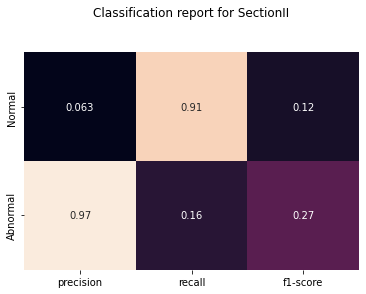

Balanced accuracy 0.5342671145821911
Accuracy 0.20325568846119255


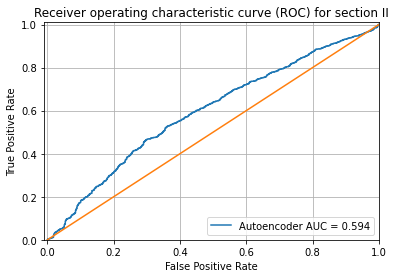

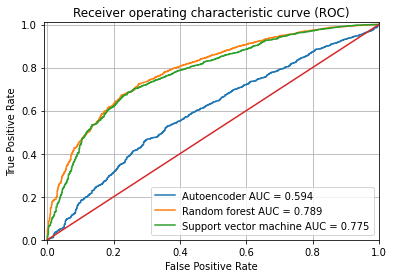

################################### SECTION III ######################################################################
(6168, 121) (6682, 121) (6939, 121)
(19789, 121)
Numbers of class instances (Raw): {0: 15624, 1: 4165}
Numbers of class instances (Raw): {0: 15624, 1: 4165}
Length of train:  15831 Length of test : 3958
Numbers of class instances (Train): {0: 12440, 1: 3391}
Numbers of class instances (Test): {0: 3184, 1: 774}
Length of train:  6782 Length of label : 6782
Numbers of class instances (Undersampling): {0: 3391, 1: 3391}
---------------Train Random forest----------------
Confusion matrix 
 [[2487  697]
 [ 151  623]]
2487 697 151 623


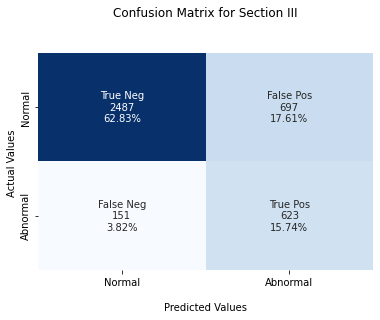

Balance Accuracy 0.7930012627738174
actual balanced accuracy formula= 0.7930012627738174
Balance Accuracy= 0.7857503789792825
Class wise accuracy [0.78109296 0.80490956]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.78      0.85      3184
           1       0.47      0.80      0.60       774

    accuracy                           0.79      3958
   macro avg       0.71      0.79      0.72      3958
weighted avg       0.85      0.79      0.80      3958

ClassificationReport 
 {'Normal': {'precision': 0.9427596664139499, 'recall': 0.7810929648241206, 'f1-score': 0.8543455857093781, 'support': 3184}, 'Abnormal': {'precision': 0.471969696969697, 'recall': 0.8049095607235142, 'f1-score': 0.5950334288443171, 'support': 774}, 'accuracy': 0.7857503789792825, 'macro avg': {'precision': 0.7073646816918234, 'recall': 0.7930012627738174, 'f1-score': 0.7246895072768476, 'support': 3958}, 'weighted avg': {'precision': 0.8506951296908949,

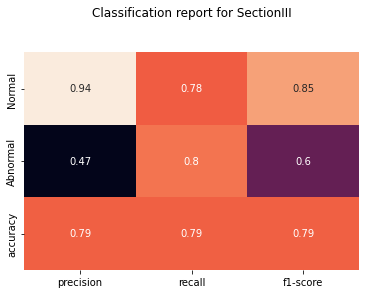

F1 weighted 0.8036362351753819
Precison weighted 0.8506951296908949
recall weighted 0.7857503789792825
Confusion matrix 



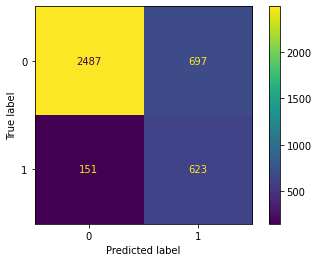

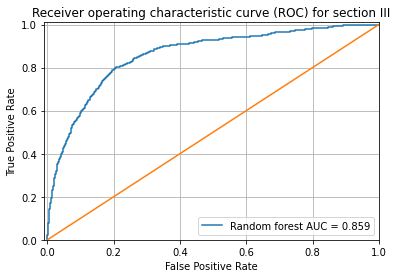

-------------------Train SVM----------------------
Confusion matrix 
 [[2561  623]
 [ 178  596]]
2561 623 178 596


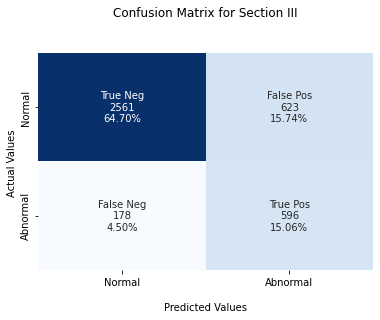

Balance Accuracy 0.7871800053237765
actual balanced accuracy formula= 0.7871800053237765
Balance Accuracy= 0.7976250631632138
Class wise accuracy [0.80433417 0.77002584]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      3184
           1       0.49      0.77      0.60       774

    accuracy                           0.80      3958
   macro avg       0.71      0.79      0.73      3958
weighted avg       0.85      0.80      0.81      3958

ClassificationReport 
 {'Normal': {'precision': 0.9350127783862724, 'recall': 0.8043341708542714, 'f1-score': 0.8647644774607463, 'support': 3184}, 'Abnormal': {'precision': 0.4889253486464315, 'recall': 0.7700258397932817, 'f1-score': 0.5980933266432514, 'support': 774}, 'accuracy': 0.7976250631632138, 'macro avg': {'precision': 0.7119690635163519, 'recall': 0.7871800053237765, 'f1-score': 0.7314289020519988, 'support': 3958}, 'weighted avg': {'precision': 0.8477789050617052

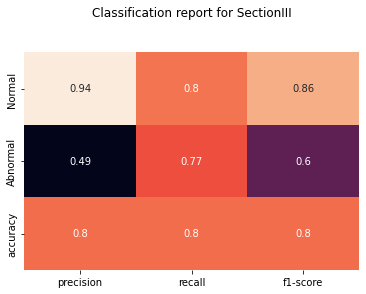

F1 weighted 0.8126160513029037
Precison weighted 0.8477789050617052
recall weighted 0.7976250631632138
Confusion matrix 



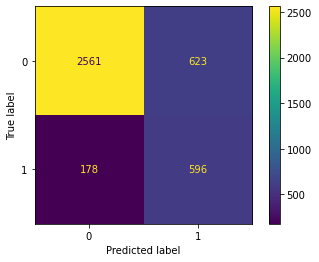

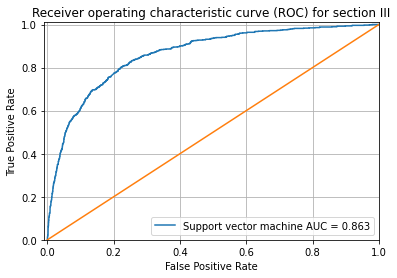

--------------------Train Autoencoder---------------
(9901, 121) (2539, 121)
Epoch 1/100
310/310 [==============================] - 3s 6ms/step - loss: 0.1455 - accuracy: 0.0479 - val_loss: 0.0684 - val_accuracy: 0.0681
Epoch 2/100
310/310 [==============================] - 1s 5ms/step - loss: 0.0381 - accuracy: 0.0678 - val_loss: 0.0205 - val_accuracy: 0.0681
Epoch 3/100
310/310 [==============================] - 1s 5ms/step - loss: 0.0157 - accuracy: 0.0678 - val_loss: 0.0133 - val_accuracy: 0.0681
Epoch 4/100
310/310 [==============================] - 1s 5ms/step - loss: 0.0129 - accuracy: 0.0678 - val_loss: 0.0127 - val_accuracy: 0.0681
Epoch 5/100
310/310 [==============================] - 2s 5ms/step - loss: 0.0127 - accuracy: 0.0678 - val_loss: 0.0127 - val_accuracy: 0.0681
Epoch 6/100
310/310 [==============================] - 1s 5ms/step - loss: 0.0127 - accuracy: 0.0678 - val_loss: 0.0127 - val_accuracy: 0.0681
Epoch 7/100
310/310 [==============================] - 2s 5ms/ste

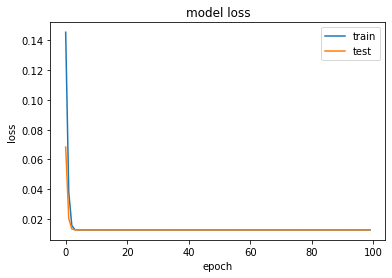

(3958, 120)


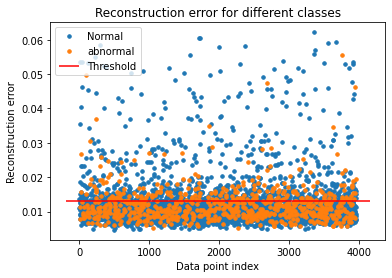

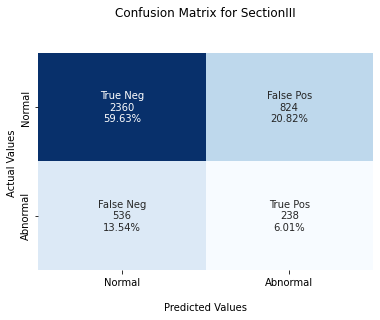

ClassificationReport 
               precision    recall  f1-score   support

           0       0.81      0.74      0.78      3184
           1       0.22      0.31      0.26       774

    accuracy                           0.66      3958
   macro avg       0.52      0.52      0.52      3958
weighted avg       0.70      0.66      0.68      3958

Classification Report 
 {'Normal': {'precision': 0.8149171270718232, 'recall': 0.7412060301507538, 'f1-score': 0.7763157894736842, 'support': 3184}, 'Abnormal': {'precision': 0.224105461393597, 'recall': 0.30749354005167956, 'f1-score': 0.25925925925925924, 'support': 774}, 'accuracy': 0.6563921172309247, 'macro avg': {'precision': 0.51951129423271, 'recall': 0.5243497851012167, 'f1-score': 0.5177875243664717, 'support': 3958}, 'weighted avg': {'precision': 0.6993819504081176, 'recall': 0.6563921172309247, 'f1-score': 0.6752036736611614, 'support': 3958}}


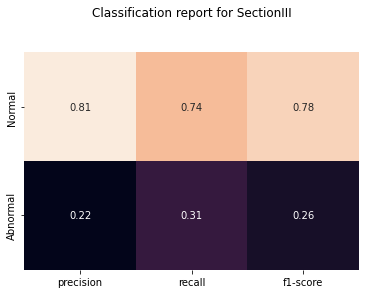

Balanced accuracy 0.5243497851012167
Accuracy 0.6563921172309247


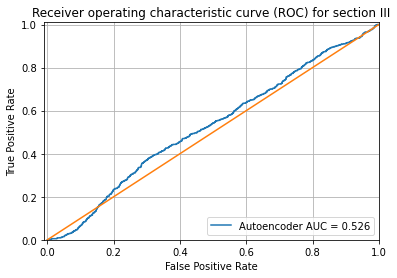

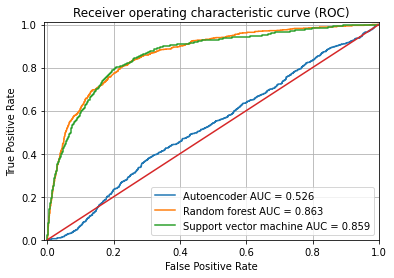

################################### SECTION IV ######################################################################
(17424, 121) (18876, 121) (19602, 121)
(55902, 121)
Numbers of class instances (Raw): {0: 45170, 1: 10732}
Numbers of class instances (Raw): {0: 45170, 1: 10732}
Length of train:  44721 Length of test : 11181
Numbers of class instances (Train): {0: 36164, 1: 8557}
Numbers of class instances (Test): {0: 9006, 1: 2175}
Length of train:  17114 Length of label : 17114
Numbers of class instances (Undersampling): {0: 8557, 1: 8557}
---------------Train Random forest----------------
Confusion matrix 
 [[6754 2252]
 [ 584 1591]]
6754 2252 584 1591


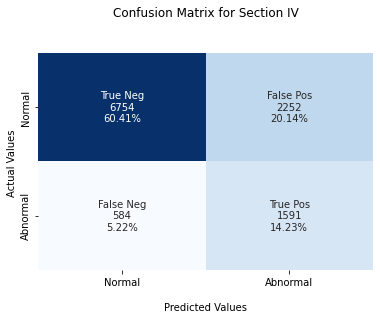

Balance Accuracy 0.7407193671651848
actual balanced accuracy formula= 0.7407193671651848
Balance Accuracy= 0.7463554243806457
Class wise accuracy [0.74994448 0.73149425]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.92      0.75      0.83      9006
           1       0.41      0.73      0.53      2175

    accuracy                           0.75     11181
   macro avg       0.67      0.74      0.68     11181
weighted avg       0.82      0.75      0.77     11181

ClassificationReport 
 {'Normal': {'precision': 0.9204142818206595, 'recall': 0.7499444814568066, 'f1-score': 0.8264806656877142, 'support': 9006}, 'Abnormal': {'precision': 0.41399947957325006, 'recall': 0.7314942528735632, 'f1-score': 0.5287470920571619, 'support': 2175}, 'accuracy': 0.7463554243806457, 'macro avg': {'precision': 0.6672068806969548, 'recall': 0.7407193671651848, 'f1-score': 0.677613878872438, 'support': 11181}, 'weighted avg': {'precision': 0.82190321886670

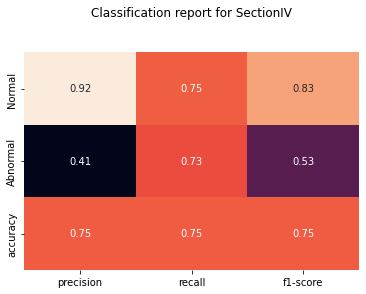

F1 weighted 0.7685636168864932
Precison weighted 0.8219032188667095
recall weighted 0.7463554243806457
Confusion matrix 



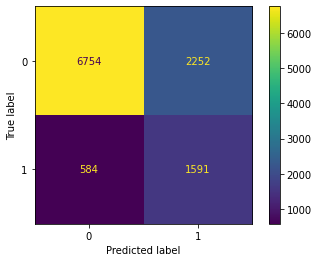

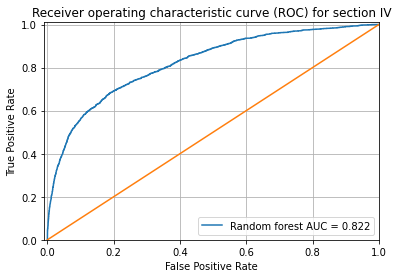

-------------------Train SVM----------------------
Confusion matrix 
 [[6810 2196]
 [ 588 1587]]
6810 2196 588 1587


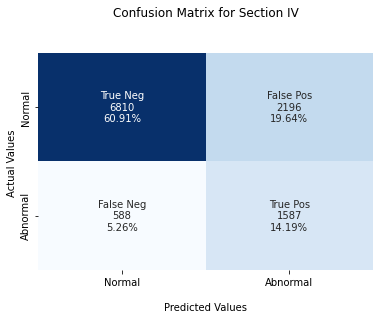

Balance Accuracy 0.7429088653541317
actual balanced accuracy formula= 0.7429088653541317
Balance Accuracy= 0.7510061711832573
Class wise accuracy [0.75616256 0.72965517]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      9006
           1       0.42      0.73      0.53      2175

    accuracy                           0.75     11181
   macro avg       0.67      0.74      0.68     11181
weighted avg       0.82      0.75      0.77     11181

ClassificationReport 
 {'Normal': {'precision': 0.9205190592051906, 'recall': 0.7561625582944703, 'f1-score': 0.8302852962692026, 'support': 9006}, 'Abnormal': {'precision': 0.4195083267248216, 'recall': 0.7296551724137931, 'f1-score': 0.5327291037260826, 'support': 2175}, 'accuracy': 0.7510061711832573, 'macro avg': {'precision': 0.6700136929650061, 'recall': 0.7429088653541317, 'f1-score': 0.6815071999976425, 'support': 11181}, 'weighted avg': {'precision': 0.82305923064380

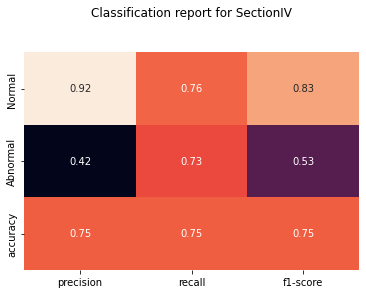

F1 weighted 0.7724027527774499
Precison weighted 0.8230592306438094
recall weighted 0.7510061711832573
Confusion matrix 



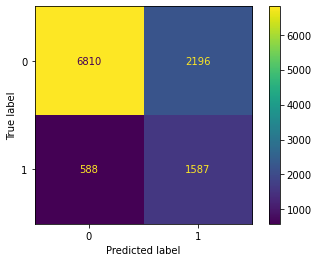

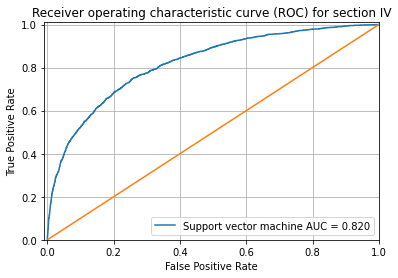

--------------------Train Autoencoder---------------
(28946, 121) (7218, 121)
Epoch 1/100
905/905 [==============================] - 5s 5ms/step - loss: 0.0191 - accuracy: 0.0402 - val_loss: 0.0118 - val_accuracy: 0.0362
Epoch 2/100
905/905 [==============================] - 4s 4ms/step - loss: 0.0118 - accuracy: 0.0460 - val_loss: 0.0114 - val_accuracy: 0.0698
Epoch 3/100
905/905 [==============================] - 3s 4ms/step - loss: 0.0113 - accuracy: 0.0642 - val_loss: 0.0109 - val_accuracy: 0.0671
Epoch 4/100
905/905 [==============================] - 4s 4ms/step - loss: 0.0111 - accuracy: 0.0693 - val_loss: 0.0108 - val_accuracy: 0.0679
Epoch 5/100
905/905 [==============================] - 3s 4ms/step - loss: 0.0102 - accuracy: 0.0642 - val_loss: 0.0100 - val_accuracy: 0.0702
Epoch 6/100
905/905 [==============================] - 4s 4ms/step - loss: 0.0100 - accuracy: 0.0707 - val_loss: 0.0099 - val_accuracy: 0.0669
Epoch 7/100
905/905 [==============================] - 4s 4ms/st

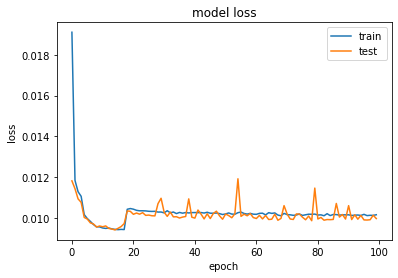

(11181, 120)


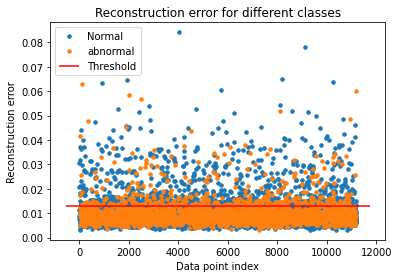

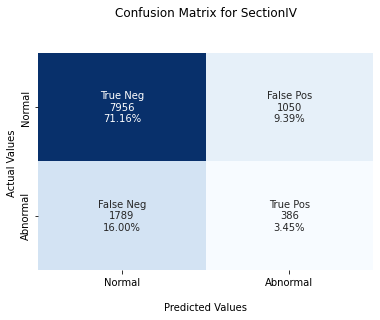

ClassificationReport 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      9006
           1       0.27      0.18      0.21      2175

    accuracy                           0.75     11181
   macro avg       0.54      0.53      0.53     11181
weighted avg       0.71      0.75      0.73     11181

Classification Report 
 {'Normal': {'precision': 0.8164186762442278, 'recall': 0.8834110592938041, 'f1-score': 0.8485947416137806, 'support': 9006}, 'Abnormal': {'precision': 0.26880222841225626, 'recall': 0.1774712643678161, 'f1-score': 0.21379119357518694, 'support': 2175}, 'accuracy': 0.7460871120651105, 'macro avg': {'precision': 0.542610452328242, 'recall': 0.5304411618308101, 'f1-score': 0.5311929675944838, 'support': 11181}, 'weighted avg': {'precision': 0.7098928043155508, 'recall': 0.7460871120651105, 'f1-score': 0.7251086744477006, 'support': 11181}}


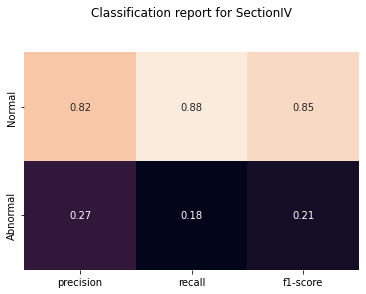

Balanced accuracy 0.5304411618308101
Accuracy 0.7460871120651105


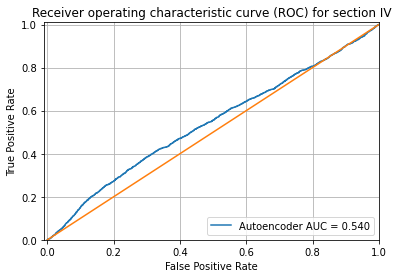

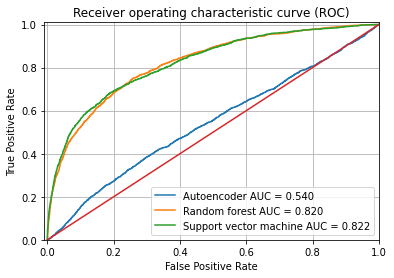

In [79]:
section=['II','III','IV']
for i,val in enumerate(section):
    print("################################### SECTION "+val+" ######################################################################")    
                    # '../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/MFCC/II.csv'
    df1=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/MFCC/'+val+'.csv',header=None)
    df2=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/'+val+'.csv',header=None)
    df3=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/'+val+'.csv',header=None)
    print(df1.shape,df2.shape,df3.shape)

    combined_df_mfcc=pd.concat([df1,df2,df3],axis=0, ignore_index=True)
    combined_df_mfcc.head()
    print(combined_df_mfcc.shape)
    # Normalize data
    norm_data= normalize_data(combined_df_mfcc)

    ## Separate data and label
    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])

    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")

    # partition data
    x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

    print("Length of train: ", len(x_train),"Length of test :", len(x_test))

    unique, counts = np.unique(y_train, return_counts=True)
    d1=dict(zip(unique, counts))
    print(f"Numbers of class instances (Train): {d1}")

    unique, counts = np.unique(y_test, return_counts=True)
    d2=dict(zip(unique, counts))
    print(f"Numbers of class instances (Test): {d2}")

    undersample_data, undersample_label=undersampling(x_train,y_train)

    print("---------------Train Random forest----------------")
    model1=train_model(undersample_data, undersample_label,'Random')
    evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test,val)
    # Random forest
    false_pos_rate2, true_pos_rate2, thresholds2 = roc_curve(np.array(y_test).ravel().astype(int),model1.predict_proba(x_test)[:,1])
    roc_auc2 = metrics.auc(false_pos_rate2, true_pos_rate2,)
    
    plt.plot(false_pos_rate2, true_pos_rate2, label='Random forest AUC = %0.3f'% roc_auc2)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

    print("-------------------Train SVM----------------------")
    model2=train_model(undersample_data, undersample_label,'SVM')
    evaluation_matrix(model2,undersample_data, undersample_label,x_test,y_test,val)
    false_pos_rate3, true_pos_rate3, thresholds3 = roc_curve(np.array(y_test).ravel().astype(int),model2.predict_proba(x_test)[:,1])
    roc_auc3 = metrics.auc(false_pos_rate3, true_pos_rate3,)    
    plt.plot(false_pos_rate3, true_pos_rate3, label='Support vector machine AUC = %0.3f'% roc_auc3)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

    print("--------------------Train Autoencoder---------------")
    x_train_new, x_val, y_train_new, y_val,indices_train,indices_test=split_data(x_train,y_train)
    train_no_cavity,train_cavity,val_no_cavity,val_cavity=split_cavity_not(x_train_new, x_val, y_train_new, y_val)
    print(train_no_cavity.shape,val_no_cavity.shape)
    model3=train_model_mfcc_auto(train_no_cavity.iloc[:,:-1], val_no_cavity.iloc[:,:-1])
    threshold=[0.015,0.013,0.013]
    evaluate_model_auto(model3, val_no_cavity.iloc[:,:-1], np.array(val_no_cavity.iloc[:,-1:]).ravel().astype(int),x_test,y_test,threshold[i],val)

    test_x_predictions = model3.predict(x_test)
    mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1)
    error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': y_test})
    error_df_test = error_df_test.reset_index()
    threshold_fixed = threshold[i]
    false_pos_rate1, true_pos_rate1, thresholds1 = roc_curve(error_df_test.True_class, error_df_test.Reconstruction_error)
    roc_auc1 = auc(false_pos_rate1, true_pos_rate1,)
    plt.plot(false_pos_rate1, true_pos_rate1, label='Autoencoder AUC = %0.3f'% roc_auc1)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()
    
    # Plot ROC curve for three
    ROC_plot(model3,model2,model1,x_test,y_test,threshold[i])

# Experiment 3: Time and frequency domain features

In [80]:
def train_model_time_psd_auto(train_no_cavity, val_no_cavity):
    nb_epoch = 100
    batch_size = 32
    input_dim = train_no_cavity.shape[1] #num of predictor variables, 
    encoding_dim = 8
    # hidden_dim = int(encoding_dim / 2)
    learning_rate = 1e-3

    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(4, activation="relu")(encoder)
    encoder = Dense(2, activation="relu")(encoder)
    
    decoder = Dense(2, activation="relu")(encoder)
    decoder = Dense(2, activation="relu")(decoder)
    decoder = Dense(encoding_dim, activation="relu")(decoder)
    decoder = Dense(input_dim, activation="linear")(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    # autoencoder.summary()

    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                                save_best_only=True,
                                verbose=0)
    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    history = autoencoder.fit(train_no_cavity, train_no_cavity,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(val_no_cavity, val_no_cavity),
                        verbose=1,
                        callbacks=[cp, tb]).history
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    return autoencoder

################################### SECTION II ######################################################################
Numbers of class instances (Raw): {0: 3243, 1: 52351}
Numbers of class instances (Raw): {0: 3243, 1: 52351}
Length of train:  44475 Length of test : 11119
Numbers of class instances (Train): {0: 2595, 1: 41880}
Numbers of class instances (Test): {0: 648, 1: 10471}
Length of train:  5190 Length of label : 5190
Numbers of class instances (Undersampling): {0: 2595, 1: 2595}
---------------Train Random forest----------------
Confusion matrix 
 [[ 483  165]
 [2863 7608]]
483 165 2863 7608


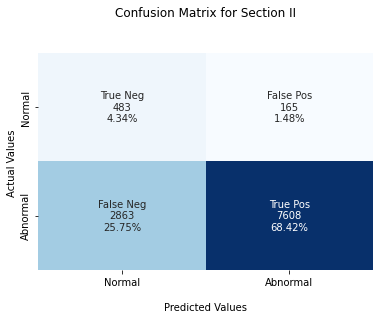

Balance Accuracy 0.7359742693223259
actual balanced accuracy formula= 0.7359742693223259
Balance Accuracy= 0.7276733519201367
Class wise accuracy [0.74537037 0.72657817]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.14      0.75      0.24       648
           1       0.98      0.73      0.83     10471

    accuracy                           0.73     11119
   macro avg       0.56      0.74      0.54     11119
weighted avg       0.93      0.73      0.80     11119

ClassificationReport 
 {'Normal': {'precision': 0.14435146443514643, 'recall': 0.7453703703703703, 'f1-score': 0.2418627941912869, 'support': 648}, 'Abnormal': {'precision': 0.978772674642995, 'recall': 0.7265781682742813, 'f1-score': 0.8340276255207192, 'support': 10471}, 'accuracy': 0.7276733519201367, 'macro avg': {'precision': 0.5615620695390707, 'recall': 0.7359742693223259, 'f1-score': 0.537945209856003, 'support': 11119}, 'weighted avg': {'precision': 0.930143756195770

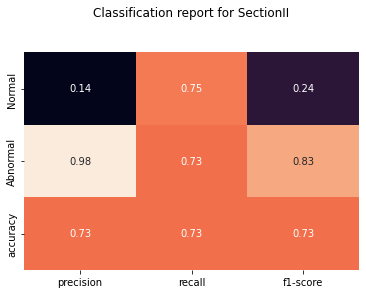

F1 weighted 0.7995170750484221
Precison weighted 0.9301437561957708
recall weighted 0.7276733519201367
Confusion matrix 



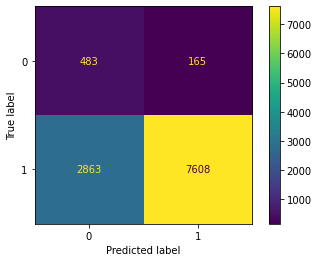

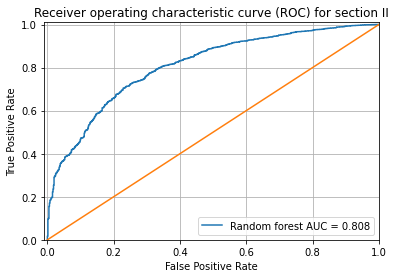

-------------------Train SVM----------------------
Confusion matrix 
 [[ 479  169]
 [4759 5712]]
479 169 4759 5712


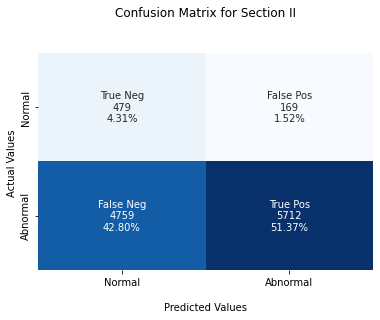

Balance Accuracy 0.6423520841218132
actual balanced accuracy formula= 0.6423520841218132
Balance Accuracy= 0.556794675780196
Class wise accuracy [0.73919753 0.54550664]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.09      0.74      0.16       648
           1       0.97      0.55      0.70     10471

    accuracy                           0.56     11119
   macro avg       0.53      0.64      0.43     11119
weighted avg       0.92      0.56      0.67     11119

ClassificationReport 
 {'Normal': {'precision': 0.0914471172203131, 'recall': 0.7391975308641975, 'f1-score': 0.16275908936459396, 'support': 648}, 'Abnormal': {'precision': 0.9712633905798334, 'recall': 0.545506637379429, 'f1-score': 0.6986301369863015, 'support': 10471}, 'accuracy': 0.556794675780196, 'macro avg': {'precision': 0.5313552539000732, 'recall': 0.6423520841218132, 'f1-score': 0.4306946131754477, 'support': 11119}, 'weighted avg': {'precision': 0.9199889103984349

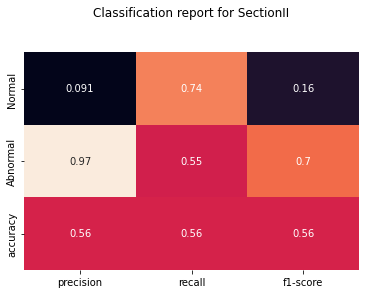

F1 weighted 0.667400310665691
Precison weighted 0.9199889103984349
recall weighted 0.5567946757801961
Confusion matrix 



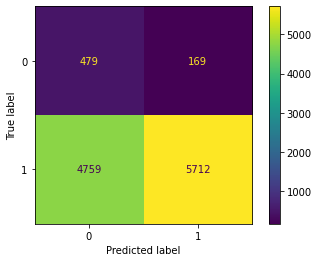

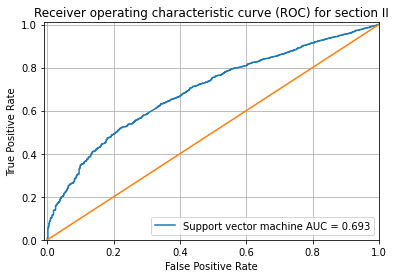

--------------------Train Autoencoder---------------
(2066, 13) (529, 13)
Epoch 1/100
65/65 [==============================] - 2s 21ms/step - loss: 0.0486 - accuracy: 0.6312 - val_loss: 0.0185 - val_accuracy: 0.6749
Epoch 2/100
65/65 [==============================] - 1s 13ms/step - loss: 0.0101 - accuracy: 0.8795 - val_loss: 0.0055 - val_accuracy: 0.9206
Epoch 3/100
65/65 [==============================] - 0s 7ms/step - loss: 0.0053 - accuracy: 0.9293 - val_loss: 0.0049 - val_accuracy: 0.9168
Epoch 4/100
65/65 [==============================] - 1s 10ms/step - loss: 0.0048 - accuracy: 0.9303 - val_loss: 0.0046 - val_accuracy: 0.9187
Epoch 5/100
65/65 [==============================] - 0s 6ms/step - loss: 0.0047 - accuracy: 0.9322 - val_loss: 0.0044 - val_accuracy: 0.9206
Epoch 6/100
65/65 [==============================] - 0s 7ms/step - loss: 0.0045 - accuracy: 0.9318 - val_loss: 0.0041 - val_accuracy: 0.9244
Epoch 7/100
65/65 [==============================] - 0s 5ms/step - loss: 0.00

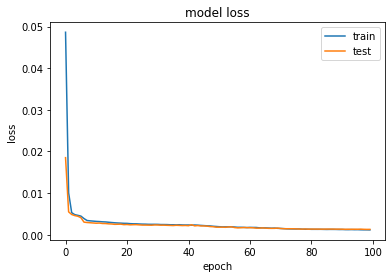

(11119, 12)


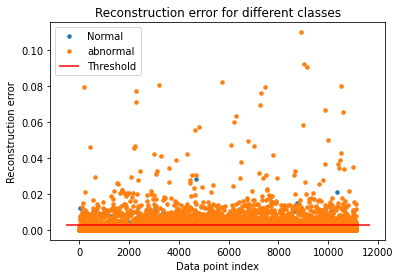

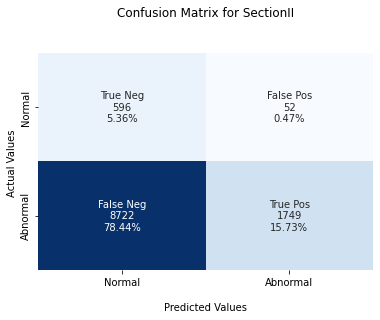

ClassificationReport 
               precision    recall  f1-score   support

           0       0.06      0.92      0.12       648
           1       0.97      0.17      0.29     10471

    accuracy                           0.21     11119
   macro avg       0.52      0.54      0.20     11119
weighted avg       0.92      0.21      0.28     11119

Classification Report 
 {'Normal': {'precision': 0.06396222365314445, 'recall': 0.9197530864197531, 'f1-score': 0.11960666265302027, 'support': 648}, 'Abnormal': {'precision': 0.9711271515824542, 'recall': 0.1670327571387642, 'f1-score': 0.28503911342894395, 'support': 10471}, 'accuracy': 0.21090026081482147, 'macro avg': {'precision': 0.5175446876177994, 'recall': 0.5433929217792586, 'f1-score': 0.2023228880409821, 'support': 11119}, 'weighted avg': {'precision': 0.9182588294942994, 'recall': 0.21090026081482147, 'f1-score': 0.27539793813415137, 'support': 11119}}


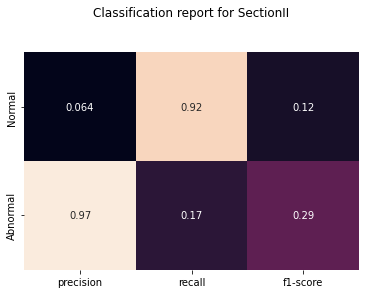

Balanced accuracy 0.5433929217792586
Accuracy 0.21090026081482147


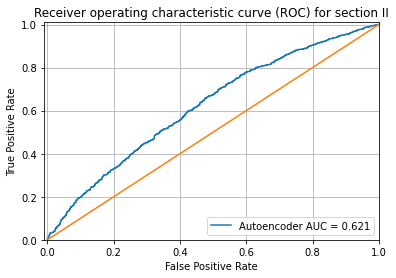

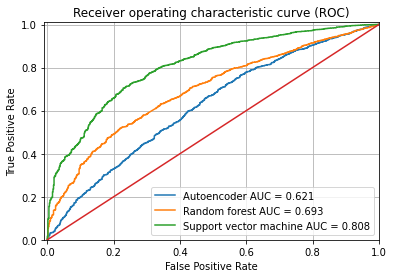

################################### SECTION III ######################################################################
Numbers of class instances (Raw): {0: 15624, 1: 4165}
Numbers of class instances (Raw): {0: 15624, 1: 4165}
Length of train:  15831 Length of test : 3958
Numbers of class instances (Train): {0: 12440, 1: 3391}
Numbers of class instances (Test): {0: 3184, 1: 774}
Length of train:  6782 Length of label : 6782
Numbers of class instances (Undersampling): {0: 3391, 1: 3391}
---------------Train Random forest----------------
Confusion matrix 
 [[2594  590]
 [ 151  623]]
2594 590 151 623


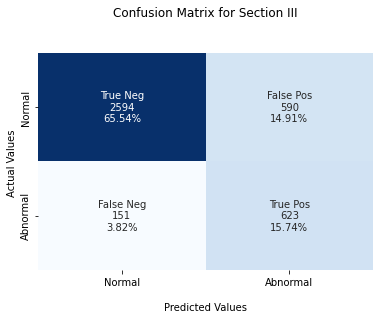

Balance Accuracy 0.8098040265929128
actual balanced accuracy formula= 0.8098040265929128
Balance Accuracy= 0.8127842344618494
Class wise accuracy [0.81469849 0.80490956]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.81      0.88      3184
           1       0.51      0.80      0.63       774

    accuracy                           0.81      3958
   macro avg       0.73      0.81      0.75      3958
weighted avg       0.86      0.81      0.83      3958

ClassificationReport 
 {'Normal': {'precision': 0.9449908925318762, 'recall': 0.8146984924623115, 'f1-score': 0.8750210828132906, 'support': 3184}, 'Abnormal': {'precision': 0.5136026380873866, 'recall': 0.8049095607235142, 'f1-score': 0.6270759939607449, 'support': 774}, 'accuracy': 0.8127842344618494, 'macro avg': {'precision': 0.7292967653096314, 'recall': 0.8098040265929128, 'f1-score': 0.7510485383870178, 'support': 3958}, 'weighted avg': {'precision': 0.8606314915869457

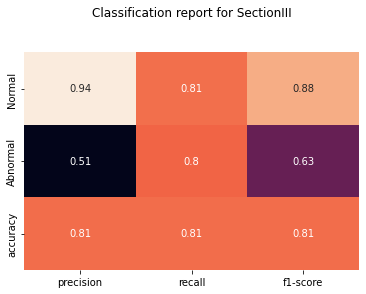

F1 weighted 0.8265346000513224
Precison weighted 0.8606314915869457
recall weighted 0.8127842344618494
Confusion matrix 



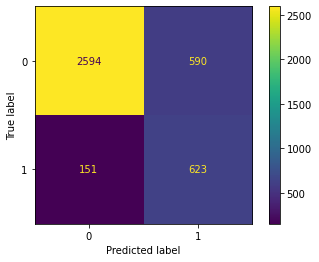

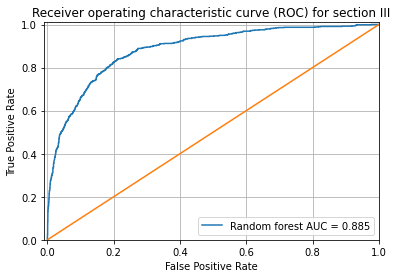

-------------------Train SVM----------------------
Confusion matrix 
 [[2364  820]
 [ 248  526]]
2364 820 248 526


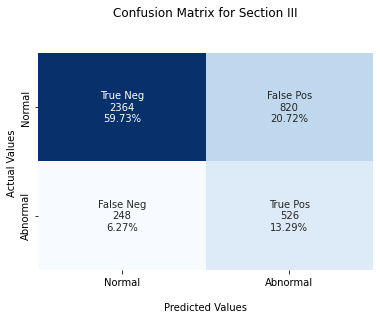

Balance Accuracy 0.7110244374326413
actual balanced accuracy formula= 0.7110244374326413
Balance Accuracy= 0.730166750884285
Class wise accuracy [0.74246231 0.67958656]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      3184
           1       0.39      0.68      0.50       774

    accuracy                           0.73      3958
   macro avg       0.65      0.71      0.66      3958
weighted avg       0.80      0.73      0.75      3958

ClassificationReport 
 {'Normal': {'precision': 0.9050535987748851, 'recall': 0.742462311557789, 'f1-score': 0.8157349896480331, 'support': 3184}, 'Abnormal': {'precision': 0.39078751857355126, 'recall': 0.6795865633074936, 'f1-score': 0.4962264150943396, 'support': 774}, 'accuracy': 0.730166750884285, 'macro avg': {'precision': 0.6479205586742182, 'recall': 0.7110244374326413, 'f1-score': 0.6559807023711863, 'support': 3958}, 'weighted avg': {'precision': 0.8044871646981211, 

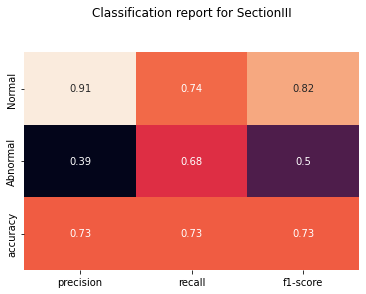

F1 weighted 0.7532540303997869
Precison weighted 0.8044871646981211
recall weighted 0.730166750884285
Confusion matrix 



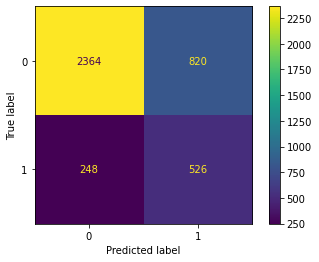

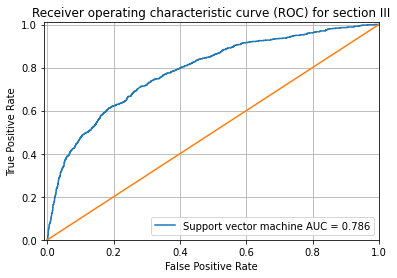

--------------------Train Autoencoder---------------
(9901, 13) (2539, 13)
Epoch 1/100
310/310 [==============================] - 2s 5ms/step - loss: 0.0217 - accuracy: 0.9393 - val_loss: 0.0050 - val_accuracy: 0.9358
Epoch 2/100
310/310 [==============================] - 1s 4ms/step - loss: 0.0037 - accuracy: 0.9259 - val_loss: 0.0027 - val_accuracy: 0.9181
Epoch 3/100
310/310 [==============================] - 1s 4ms/step - loss: 0.0014 - accuracy: 0.9407 - val_loss: 0.0012 - val_accuracy: 0.9484
Epoch 4/100
310/310 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.9494 - val_loss: 8.9591e-04 - val_accuracy: 0.9476
Epoch 5/100
310/310 [==============================] - 1s 3ms/step - loss: 7.1781e-04 - accuracy: 0.9539 - val_loss: 5.9640e-04 - val_accuracy: 0.9559
Epoch 6/100
310/310 [==============================] - 1s 4ms/step - loss: 5.5631e-04 - accuracy: 0.9588 - val_loss: 5.0948e-04 - val_accuracy: 0.9531
Epoch 7/100
310/310 [==========================

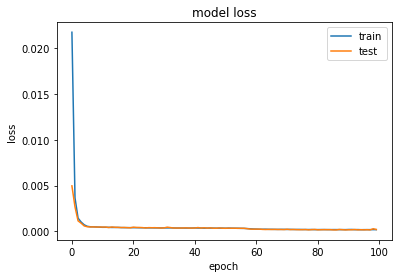

(3958, 12)


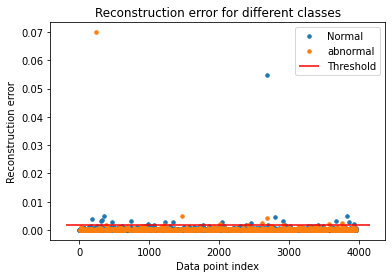

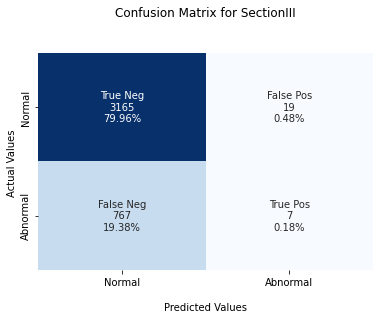

ClassificationReport 
               precision    recall  f1-score   support

           0       0.80      0.99      0.89      3184
           1       0.27      0.01      0.02       774

    accuracy                           0.80      3958
   macro avg       0.54      0.50      0.45      3958
weighted avg       0.70      0.80      0.72      3958

Classification Report 
 {'Normal': {'precision': 0.8049338758901322, 'recall': 0.9940326633165829, 'f1-score': 0.8895446880269814, 'support': 3184}, 'Abnormal': {'precision': 0.2692307692307692, 'recall': 0.00904392764857881, 'f1-score': 0.017499999999999998, 'support': 774}, 'accuracy': 0.8014148559878727, 'macro avg': {'precision': 0.5370823225604507, 'recall': 0.5015382954825809, 'f1-score': 0.4535223440134907, 'support': 3958}, 'weighted avg': {'precision': 0.7001753603382507, 'recall': 0.8014148559878727, 'f1-score': 0.7190134630313059, 'support': 3958}}


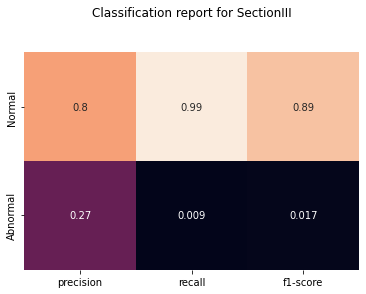

Balanced accuracy 0.5015382954825809
Accuracy 0.8014148559878727


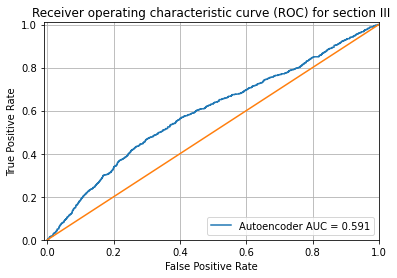

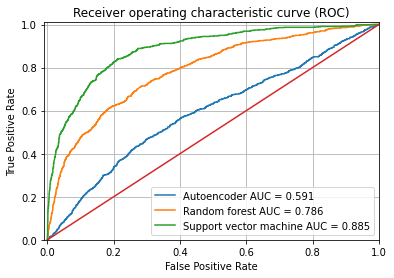

################################### SECTION IV ######################################################################
Numbers of class instances (Raw): {0: 45170, 1: 10732}
Numbers of class instances (Raw): {0: 45170, 1: 10732}
Length of train:  44721 Length of test : 11181
Numbers of class instances (Train): {0: 36164, 1: 8557}
Numbers of class instances (Test): {0: 9006, 1: 2175}
Length of train:  17114 Length of label : 17114
Numbers of class instances (Undersampling): {0: 8557, 1: 8557}
---------------Train Random forest----------------
Confusion matrix 
 [[7321 1685]
 [ 511 1664]]
7321 1685 511 1664


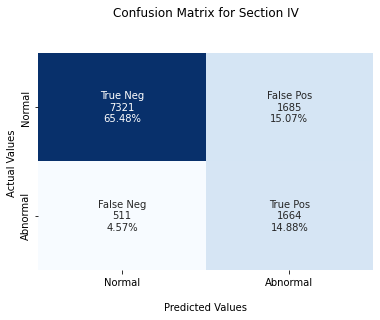

Balance Accuracy 0.7889799903512601
actual balanced accuracy formula= 0.7889799903512601
Balance Accuracy= 0.8035953850281728
Class wise accuracy [0.81290251 0.76505747]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      9006
           1       0.50      0.77      0.60      2175

    accuracy                           0.80     11181
   macro avg       0.72      0.79      0.74     11181
weighted avg       0.85      0.80      0.82     11181

ClassificationReport 
 {'Normal': {'precision': 0.9347548518896833, 'recall': 0.8129025094381523, 'f1-score': 0.8695807102981352, 'support': 9006}, 'Abnormal': {'precision': 0.49686473574201256, 'recall': 0.7650574712643678, 'f1-score': 0.6024619840695149, 'support': 2175}, 'accuracy': 0.8035953850281728, 'macro avg': {'precision': 0.715809793815848, 'recall': 0.7889799903512601, 'f1-score': 0.7360213471838251, 'support': 11181}, 'weighted avg': {'precision': 0.84957365140482

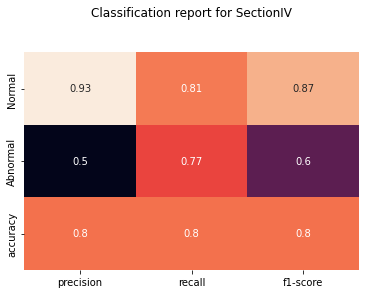

F1 weighted 0.8176190584291388
Precison weighted 0.8495736514048265
recall weighted 0.8035953850281728
Confusion matrix 



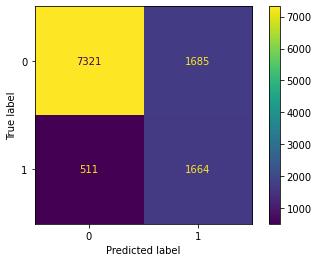

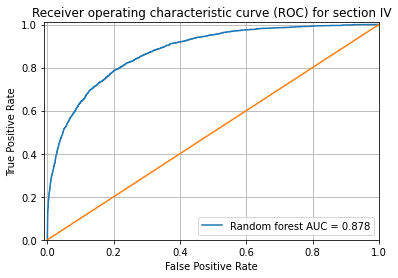

-------------------Train SVM----------------------
Confusion matrix 
 [[6753 2253]
 [ 615 1560]]
6753 2253 615 1560


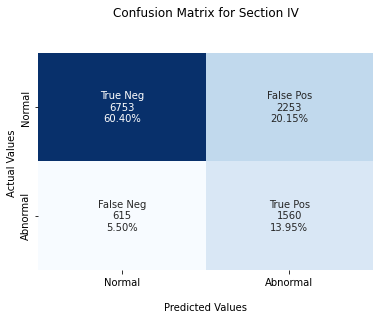

Balance Accuracy 0.7335374118403823
actual balanced accuracy formula= 0.7335374118403823
Balance Accuracy= 0.7434934263482694
Class wise accuracy [0.74983344 0.71724138]
ClassificationReport 
               precision    recall  f1-score   support

           0       0.92      0.75      0.82      9006
           1       0.41      0.72      0.52      2175

    accuracy                           0.74     11181
   macro avg       0.66      0.73      0.67     11181
weighted avg       0.82      0.74      0.77     11181

ClassificationReport 
 {'Normal': {'precision': 0.9165309446254072, 'recall': 0.7498334443704198, 'f1-score': 0.8248442652986443, 'support': 9006}, 'Abnormal': {'precision': 0.4091266719118804, 'recall': 0.7172413793103448, 'f1-score': 0.5210420841683366, 'support': 2175}, 'accuracy': 0.7434934263482694, 'macro avg': {'precision': 0.6628288082686438, 'recall': 0.7335374118403823, 'f1-score': 0.6729431747334904, 'support': 11181}, 'weighted avg': {'precision': 0.81782740351531

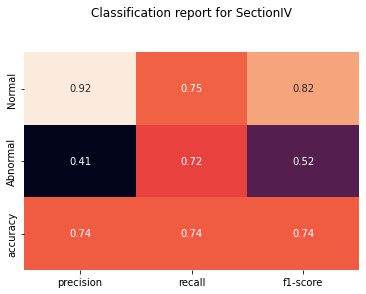

F1 weighted 0.7657467119529312
Precison weighted 0.8178274035153168
recall weighted 0.7434934263482694
Confusion matrix 



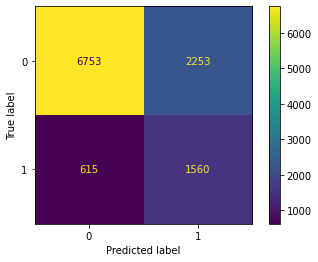

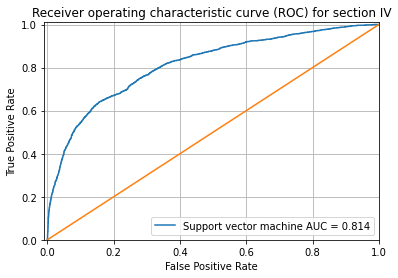

--------------------Train Autoencoder---------------
(28946, 13) (7218, 13)
Epoch 1/100
905/905 [==============================] - 5s 4ms/step - loss: 0.0106 - accuracy: 0.9907 - val_loss: 0.0020 - val_accuracy: 0.9967
Epoch 2/100
905/905 [==============================] - 4s 4ms/step - loss: 0.0020 - accuracy: 0.9949 - val_loss: 0.0018 - val_accuracy: 0.9957
Epoch 3/100
905/905 [==============================] - 4s 4ms/step - loss: 0.0014 - accuracy: 0.9881 - val_loss: 0.0013 - val_accuracy: 0.9953
Epoch 4/100
905/905 [==============================] - 4s 4ms/step - loss: 0.0012 - accuracy: 0.9934 - val_loss: 0.0012 - val_accuracy: 0.9935
Epoch 5/100
905/905 [==============================] - 5s 6ms/step - loss: 0.0011 - accuracy: 0.9935 - val_loss: 0.0011 - val_accuracy: 0.9945
Epoch 6/100
905/905 [==============================] - 4s 4ms/step - loss: 0.0011 - accuracy: 0.9948 - val_loss: 0.0011 - val_accuracy: 0.9942
Epoch 7/100
905/905 [==============================] - 4s 5ms/step

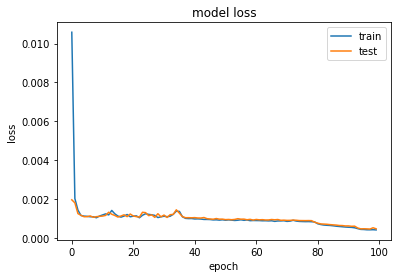

(11181, 12)


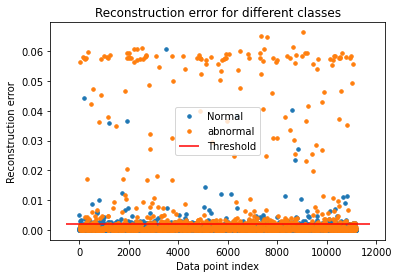

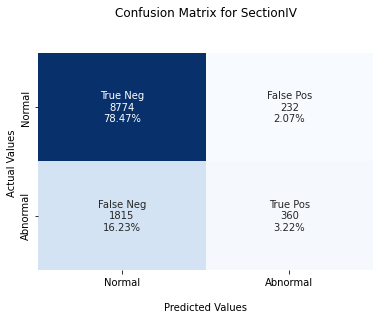

ClassificationReport 
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      9006
           1       0.61      0.17      0.26      2175

    accuracy                           0.82     11181
   macro avg       0.72      0.57      0.58     11181
weighted avg       0.79      0.82      0.77     11181

Classification Report 
 {'Normal': {'precision': 0.8285957125318727, 'recall': 0.97423939595825, 'f1-score': 0.8955345751467211, 'support': 9006}, 'Abnormal': {'precision': 0.6081081081081081, 'recall': 0.16551724137931034, 'f1-score': 0.26020961329960246, 'support': 2175}, 'accuracy': 0.8169215633664252, 'macro avg': {'precision': 0.7183519103199905, 'recall': 0.5698783186687801, 'f1-score': 0.5778720942231618, 'support': 11181}, 'weighted avg': {'precision': 0.785705046256791, 'recall': 0.8169215633664252, 'f1-score': 0.771947079214561, 'support': 11181}}


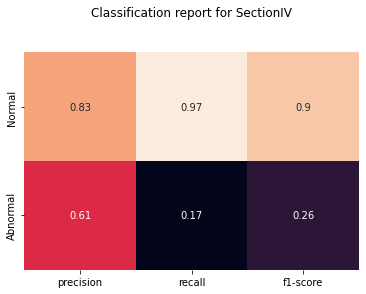

Balanced accuracy 0.5698783186687801
Accuracy 0.8169215633664252


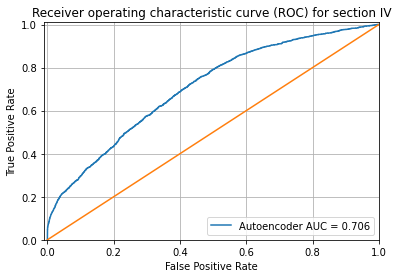

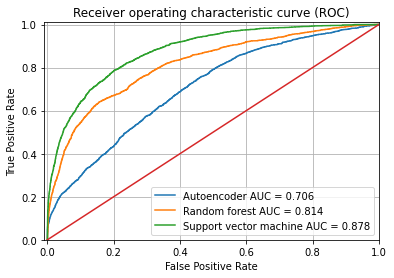

In [81]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
section=['II','III','IV']
for i,val in enumerate(section):
    print("################################### SECTION "+val+" ######################################################################") 
    df1=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/'+val+'.csv',names=time_col_list)
    df2=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/'+val+'.csv',names=time_col_list)
    df3=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/'+val+'.csv',names=time_col_list)

    new_df1=df1[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]
    new_df2=df2[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]
    new_df3=df3[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

    combined_df_time=pd.concat([new_df1,new_df2,new_df3],names=['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label'],ignore_index=True)
    combined_df_time.head()

    df4=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/PSD/'+val+'.csv',header=None)
    df5=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/PSD/'+val+'.csv',header=None)
    df6=pd.read_csv('../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/'+val+'.csv',header=None)
    combined_df_psd=pd.concat([df4,df5,df6],ignore_index=True)
    combined_df_psd.rename(columns={combined_df_psd.columns[-1]: "label" }, inplace = True)  
    combined_df_psd.head()

    combined_time_psd=pd.concat([combined_df_time.iloc[:,:-1],combined_df_psd.iloc[:,:-1],combined_df_time.iloc[:,-1:]],axis=1,ignore_index=True)

    ## Normalize data
    norm_data= normalize_data(combined_time_psd)

    ## Separate data and label
    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])

    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")

    # partition data
    x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

    print("Length of train: ", len(x_train),"Length of test :", len(x_test))

    unique, counts = np.unique(y_train, return_counts=True)
    d1=dict(zip(unique, counts))
    print(f"Numbers of class instances (Train): {d1}")

    unique, counts = np.unique(y_test, return_counts=True)
    d2=dict(zip(unique, counts))
    print(f"Numbers of class instances (Test): {d2}")

    undersample_data, undersample_label=undersampling(x_train,y_train)

   


    print("---------------Train Random forest----------------")
    model1=train_model(undersample_data, undersample_label,'Random')
    evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test,val)
    # Random forest
    false_pos_rate2, true_pos_rate2, thresholds2 = roc_curve(np.array(y_test).ravel().astype(int),model1.predict_proba(x_test)[:,1])
    roc_auc2 = metrics.auc(false_pos_rate2, true_pos_rate2,)
    
    plt.plot(false_pos_rate2, true_pos_rate2, label='Random forest AUC = %0.3f'% roc_auc2)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

    print("-------------------Train SVM----------------------")
    model2=train_model(undersample_data, undersample_label,'SVM')
    evaluation_matrix(model2,undersample_data, undersample_label,x_test,y_test,val)
    false_pos_rate3, true_pos_rate3, thresholds3 = roc_curve(np.array(y_test).ravel().astype(int),model2.predict_proba(x_test)[:,1])
    roc_auc3 = metrics.auc(false_pos_rate3, true_pos_rate3,)    
    plt.plot(false_pos_rate3, true_pos_rate3, label='Support vector machine AUC = %0.3f'% roc_auc3)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()

    print("--------------------Train Autoencoder---------------")
    x_train_new, x_val, y_train_new, y_val,indices_train,indices_test=split_data(x_train,y_train)
    train_no_cavity,train_cavity,val_no_cavity,val_cavity=split_cavity_not(x_train_new, x_val, y_train_new, y_val)
    print(train_no_cavity.shape,val_no_cavity.shape)
    model3=train_model_mfcc_auto(train_no_cavity.iloc[:,:-1], val_no_cavity.iloc[:,:-1])
    threshold=[0.0025,0.0019,0.0019]
    evaluate_model_auto(model3, val_no_cavity.iloc[:,:-1], np.array(val_no_cavity.iloc[:,-1:]).ravel().astype(int),x_test,y_test,threshold[i],val)

    test_x_predictions = model3.predict(x_test)
    mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1)
    error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                            'True_class': y_test})
    error_df_test = error_df_test.reset_index()
    threshold_fixed = threshold[i]
    false_pos_rate1, true_pos_rate1, thresholds1 = roc_curve(error_df_test.True_class, error_df_test.Reconstruction_error)
    roc_auc1 = auc(false_pos_rate1, true_pos_rate1,)
    plt.plot(false_pos_rate1, true_pos_rate1, label='Autoencoder AUC = %0.3f'% roc_auc1)
    plt.plot([0,1],[0,1])
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC) for section '+val)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()
    
    # Plot ROC curve for three
    ROC_plot(model3,model2,model1,x_test,y_test,threshold[i])